## Regional Financial Vulnerability Index (RFVI) Construction and Aggregation

This notebook constructs the **Regional Financial Vulnerability Index (RFVI)** using previously derived **Sensitivity, Resilience, and Exposure (S-R-E) factor scores**.

It performs the full process from geographic validation to final regional ranking:
- Validates the presence, consistency, and completeness of geographic variables (`Region`, `Urban_RuralFIES`)
- Standardizes regional naming across survey months
- Computes household-level RFVI using normalized S-R-E scores
- Aggregates RFVI at the regional level
- Generates:
  - Monthly regional rankings (2018-2024)
  - Overall regional mean ranking
  - Visualization outputs for interpretation

This notebook:
- Ensures methodological consistency before geographic aggregation
- Confirms that RFVI is computed only where regional identifiers are valid
- Produces comparable regional vulnerability scores across time
- Identifies regions with persistently higher or lower financial vulnerability

Survey files with RFVI are stored in `FINAL Survey Datasets with Factor Scores and RFVI` folder.

This notebook operationalizes the RFVI framework and translates household-level vulnerability into interpretable regional insights.

---
#### Geographic Variable Validation Prior to RFVI Aggregation

The construction of the Regional Financial Vulnerability Index (RFVI) requires the aggregation of household-level factor scores at a defined geographic level. While the initial proposal considered presenting selected cities or provinces for additional granularity, data validation revealed that city- and province-level aggregation is not feasible across survey months. 

As a result, financial vulnerability will be aggregated at the **regional level**, where the `Region` variable is present and structurally interpretable.

1. **Region (Primary Aggregation Variable)**

Because `Region` serves as the primary unit of spatial analysis, it must be validated for consistency, completeness, and stability across survey waves. 

Before aggregation, the following must be verified:

- Presence of the variable across survey months
- Consistency of naming conventions
- Absence of missing or inconsistent entries

This validation prevents artificial fragmentation of regions and preserves comparability of regional averages over time.

2. **Urban-Rural Classification (Contextual Geographic Indicator)**

The `Urban_RuralFIES` variable is assessed for contextual interpretation. Although excluded from factor extraction due to inconsistent availability across months, it remains relevant as a supporting variable as existing studies show that **urban-rural location influences financial vulnerability**.

**Where available, this variable may therefore be used as a descriptive geographic stratifier to provide additional insight into vulnerability patterns**, without altering the structural computation of the RFVI.

Its inclusion does not alter the structural computation of the RFVI but enhances contextual understanding where data is available.

#### Other Geographic Variables Not Viable as Units of Analysis

Other geographic identifiers were evaluated but will not be used for methodological reasons:

1. **Province**

- No metadata for decoding raw numeric codes
- Contains raw numeric values that are not interpretable.

2. **Location of Work**

- Reflects workplace rather than residence
- May differ from the household’s actual region
- Would introduce spatial misclassification bias

Due to these limitations, province- or city-level aggregation is not methodologically viable. RFVI aggregation is therefore conducted at the **regional level**, ensuring consistency, interpretability, and alignment with the validated structure of the dataset.

---
### Audit of Variable Presence Across Survey Months

Before aggregation, we verify whether the `Region` and `Urban_RuralFIES` variables are present in each survey month.

Since RFVI will be constructed at the **regional level**, aggregation is only possible for months where the Region variable exists.

**What this code does:**
- Scans all monthly survey folders
- Records which months contain:
  - Region
  - Urban_RuralFIES
- Generates a presence report

**Why this matters:**
- Ensures transparency about data availability
- Identifies months that cannot be used for RFVI construction
- Confirms whether Urban-Rural stratification is feasible

In [1]:
import pandas as pd
import numpy as np
import os
import json
from pathlib import Path

# --- 1. SETUP & CONFIGURATION ---
try:
    with open(Path("./data/interim/config.json")) as f:
        cfg = json.load(f)
    BASE_PATH = Path(cfg["BASE_PATH"])
    
    # Targeting the specific folder with merged SRE scores
    DATA_SOURCE = BASE_PATH / "Survey Datasets with Factor Scores"
    
    URBAN_RURAL_COL = 'Urban_RuralFIES'
    REGION_COL = 'Region'

    print("Configuration Loaded.")
    print(f"Data Source: {DATA_SOURCE}")
except Exception as e:
    print(f"Error loading config: {e}")

# --- 2. AUDIT LOGIC ---
if DATA_SOURCE.exists():
    # Folder structure is Year_Month (e.g., 2018_April)
    month_folders = sorted([f for f in os.listdir(DATA_SOURCE) if (DATA_SOURCE / f).is_dir()])
    
    region_present = []
    region_missing = []
    ur_present = []
    ur_missing = []

    print(f"Scanning {len(month_folders)} survey month folders...")

    for folder in month_folders:
        folder_path = DATA_SOURCE / folder
        # Files are named: Final_SRE_Full_...
        csv_files = list(folder_path.glob("Final_SRE_Full_*.csv"))
        
        if not csv_files:
            continue
            
        target_file = csv_files[0]
        
        # Format the display name (2018_April -> April 2018)
        try:
            year_part, month_part = folder.split('_')
            display_name = f"{month_part} {year_part}"
        except:
            display_name = folder 

        # Speed optimization: Read only headers
        headers = pd.read_csv(target_file, nrows=0).columns.tolist()
        
        # Audit Presence for Region
        if REGION_COL in headers:
            region_present.append(display_name)
        else:
            region_missing.append(display_name)
            
        # Audit Presence for Urban-Rural
        if URBAN_RURAL_COL in headers:
            ur_present.append(display_name)
        else:
            ur_missing.append(display_name)

    # --- 3. PRINTED REPORT ---
    print("\n" + "="*60)
    print("VARIABLE PRESENCE REPORT: SURVEY DATASETS WITH FACTOR SCORES")
    print("="*60)

    # Region Report
    print(f"\n{REGION_COL}:")
    print(f"Present in {len(region_present)} months: {', '.join(region_present) if region_present else 'None'}")
    if region_missing:
        print(f"Missing in {len(region_missing)} months: {', '.join(region_missing)}")
    else:
        print("Missing in: None")

    # Urban-Rural Report
    print(f"\n{URBAN_RURAL_COL}:")
    print(f"Present in {len(ur_present)} months: {', '.join(ur_present) if ur_present else 'None'}")
    if ur_missing:
        print(f"Missing in {len(ur_missing)} months: {', '.join(ur_missing)}")
    else:
        print("Missing in: None")
        
    print("\n" + "="*60)

else:
    print(f"Data source path not found: {DATA_SOURCE}")

Configuration Loaded.
Data Source: H:\.shortcut-targets-by-id\1VctTphaltRx4xcPxmTJlRTrxLalyuEt8\Labor Force Survey\Survey Datasets with Factor Scores
Scanning 40 survey month folders...

VARIABLE PRESENCE REPORT: SURVEY DATASETS WITH FACTOR SCORES

Region:
Present in 37 months: April 2018, January 2018, July 2018, October 2018, April 2019, January 2019, July 2019, October 2019, April 2022, August 2022, December 2022, February 2022, January 2022, July 2022, June 2022, March 2022, May 2022, November 2022, October 2022, September 2022, April 2023, August 2023, December 2023, February 2023, January 2023, July 2023, June 2023, March 2023, May 2023, November 2023, October 2023, September 2023, April 2024, February 2024, January 2024, July 2024, March 2024
Missing in 3 months: August 2024, June 2024, May 2024

Urban_RuralFIES:
Present in 27 months: April 2018, January 2018, July 2018, October 2018, April 2019, January 2019, July 2019, October 2019, April 2022, August 2022, December 2022, Febr

Key Insight:

- The `Region` variable is available in **37 out of 40** survey months, making regional aggregation largely feasible. However, it is completely **missing in May, June, and August 2024**, meaning RFVI cannot be computed for these months.
- The `Urban_RuralFIES` variable is available in only 27 months, meaning classification can only be done in these months.

---
### Geographic Value Consistency and Completeness Audit

After confirming variable presence, we check whether the **values inside those variables are consistent across months.**

Even if a column exists, inconsistencies in naming (e.g., spacing, capitalization, alternate spellings) can distort aggregation.

**What this code does:**
- Scans all files
- Extracts unique values for:
  - Region
  - Urban-Rural classification
- Checks:
  - Naming consistency across months
  - Missing value counts

**Why this matters:**
- Prevents artificial fragmentation of regions (e.g., “Region IV-A” vs “Region IVA”)
- Detects naming variations
- Quantifies missing geographic information
- Confirms structural consistency of geographic identifiers.

In [2]:
import pandas as pd
import numpy as np
import os
import json
from pathlib import Path

# --- 1. SETUP & CONFIGURATION ---
try:
    with open(Path("./data/interim/config.json")) as f:
        cfg = json.load(f)
    BASE_PATH = Path(cfg["BASE_PATH"])
    
    # Target: The folder containing the final merged scores
    DATA_SOURCE = BASE_PATH / "Survey Datasets with Factor Scores"
    CACHE_FILE = Path("./data/interim/geographic_audit_cache.json")
    
    # Sanitized names from the Imputation/SRE step
    URBAN_RURAL_COL = 'Urban_RuralFIES' 
    REGION_COL = 'Region'

    print("Configuration Loaded.")
except Exception as e:
    print(f"Error loading config: {e}")

# --- 2. CACHE CHECK & AUDIT LOGIC ---
audit_results = None

if CACHE_FILE.exists():
    print(" Loading geographic audit from local cache... (Instant)")
    with open(CACHE_FILE, 'r') as f:
        audit_results = json.load(f)
else:
    if DATA_SOURCE.exists():
        # rglob handles the Year_Month subfolder structure
        all_csv_files = sorted(list(DATA_SOURCE.rglob("Final_SRE_Full_*.csv")))
        
        all_regions = set()
        all_ur_values = set()
        monthly_region_sets = {}
        monthly_ur_sets = {}
        region_missing_total = 0
        ur_missing_total = 0
        total_rows_scanned = 0

        print(" No cache found. Starting one-time consistency and completeness check...")

        for target_file in all_csv_files:
            # folder_label will be e.g., '2018_April'
            folder_label = target_file.parent.name 
            print(f" Checking {folder_label}...", end="\r")
            
            # Identify columns present
            headers = pd.read_csv(target_file, nrows=0).columns.tolist()
            cols_to_load = [c for c in [REGION_COL, URBAN_RURAL_COL] if c in headers]
            
            if cols_to_load:
                # Chunking for high-column-count files
                chunks = pd.read_csv(target_file, usecols=cols_to_load, chunksize=150000, engine='c')
                
                m_reg_set = set()
                m_ur_set = set()
                
                for chunk in chunks:
                    total_rows_scanned += len(chunk)
                    
                    if REGION_COL in chunk.columns:
                        clean_reg = chunk[REGION_COL].dropna().astype(str).str.strip().str.lower()
                        m_reg_set.update(clean_reg.unique())
                        region_missing_total += int(chunk[REGION_COL].isnull().sum())
                        
                    if URBAN_RURAL_COL in chunk.columns:
                        clean_ur = chunk[URBAN_RURAL_COL].dropna().astype(str).str.strip().str.lower()
                        m_ur_set.update(clean_ur.unique())
                        ur_missing_total += int(chunk[URBAN_RURAL_COL].isnull().sum())
                
                all_regions.update(m_reg_set)
                all_ur_values.update(m_ur_set)
                monthly_region_sets[folder_label] = list(m_reg_set)
                monthly_ur_sets[folder_label] = list(m_ur_set)

        # Save to Cache
        audit_results = {
            "all_regions": sorted(list(all_regions)),
            "all_ur_values": sorted(list(all_ur_values)),
            "monthly_region_sets": monthly_region_sets,
            "monthly_ur_sets": monthly_ur_sets,
            "region_missing": region_missing_total,
            "ur_missing": ur_missing_total,
            "total_rows": total_rows_scanned
        }
        
        with open(CACHE_FILE, 'w') as f:
            json.dump(audit_results, f)
        print("\n Scan complete. Results saved locally.")
    else:
        print(f"Data source path not found: {DATA_SOURCE}")

# --- 3. OUTPUT GENERATION (Cleaned Report) ---
if audit_results:
    print("\nUnique Values Found:")
    print("-" * 30)
    print(f"--- {REGION_COL} ({len(audit_results['all_regions'])}) ---")
    for val in audit_results['all_regions']:
        print(val)
    
    # Consistency Check
    master_reg = set(audit_results['all_regions'])
    reg_consistent = all(set(s) == master_reg for s in audit_results['monthly_region_sets'].values())
    print(f"\nRegional values are {'consistent' if reg_consistent else 'inconsistent (naming variations found)'} across months.")

    print(f"\n--- {URBAN_RURAL_COL} ({len(audit_results['all_ur_values'])}) ---")
    for val in audit_results['all_ur_values']:
        print(val)
        
    master_ur = set(audit_results['all_ur_values'])
    ur_consistent = all(set(s) == master_ur for s in audit_results['monthly_ur_sets'].values())
    print(f"\nUrban-Rural values are {'consistent' if ur_consistent else 'inconsistent'} across months.")

    print("\nCompleteness Status:")
    print("-" * 30)
    print(f"{REGION_COL}: {'100% complete' if audit_results['region_missing'] == 0 else f'{audit_results['region_missing']} missing values found'}")
    print(f"{URBAN_RURAL_COL}: {'100% complete' if audit_results['ur_missing'] == 0 else f'{audit_results['ur_missing']} missing values found'}")

Configuration Loaded.
 Loading geographic audit from local cache... (Instant)

Unique Values Found:
------------------------------
--- Region (50) ---
autonomous region in muslim mindanao
autonomous region in muslim mindanao  (armm)
autonomous region in muslim mindanao (armm)
cordillera administrative region
cordillera administrative region  (car)
cordillera administrative region (car)
mimaropa region
national capital region
national capital region  (ncr)
national capital region (ncr)
region i  (ilocos region)
region i (ilocos region)
region i - ilocos region
region ii  (cagayan valley)
region ii (cagayan valley)
region ii - cagayan valley
region iii  (central luzon)
region iii (central luzon)
region iii - central luzon
region iv-a  (calabarzon)
region iv-a (calabarzon)
region iva - calabarzon
region ivb - mimaropa
region ix  (zamboanga peninsula)
region ix (zamboanga peninsula)
region ix - zamboanga peninsula
region v  (bicol region)
region v (bicol region)
region v- bicol
region vi  

Key Insight:

- The `Region` variable shows **multiple naming variations** (e.g., spacing, capitalization, alternate formats), which could fragment aggregation if not standardized. Despite naming inconsistencies, the variable is **100% complete** in months where it exists.
- The `Urban_RuralFIES` variable contains only two values (“urban” and “rural”) and is **100% complete** in months where it exists.

Implication:

Regional labels require standardization before aggregation to prevent artificial splitting of regions. Once cleaned, the geographic structure is complete and reliable.

---
### Region Standardization and Urban-Rural Stability Assessment

After detecting naming variations, we standardize region names using a predefined `region_map` according to the naming variations of the regions.

This ensures that **all regional identifiers follow a single official format** before aggregation.

**What this code does:**
- Applies standardized region mapping
- Computes Urban vs Rural distribution per region per month
- Assesses whether:
  - All standardized regions appear consistently
  - Urban-Rural composition is stable across months

**Why this matters:**
- Guarantees clean regional aggregation
- Prevents duplication caused by naming inconsistencies
- Validates the structural integrity of geographic data

In [ ]:
import pandas as pd
import numpy as np
import os
import gc
from pathlib import Path

# --- 1. LOCAL DEFINITIONS ---
DATA_SOURCE = BASE_PATH / "Survey Datasets with Factor Scores"
CACHE_PATH = Path("./data/interim/urban_rural_stability_audit.csv")

URBAN_RURAL_COL = 'Urban_RuralFIES'
REGION_COL = 'Region'

region_map = {
    'national capital region': 'National Capital Region (NCR)',
    'national capital region  (ncr)': 'National Capital Region (NCR)',
    'national capital region (ncr)': 'National Capital Region (NCR)',
    'cordillera administrative region': 'Cordillera Administrative Region (CAR)',
    'cordillera administrative region  (car)': 'Cordillera Administrative Region (CAR)',
    'cordillera administrative region (car)': 'Cordillera Administrative Region (CAR)',
    'autonomous region in muslim mindanao': 'Autonomous Region in Muslim Mindanao (ARMM)',
    'autonomous region in muslim mindanao  (armm)': 'Autonomous Region in Muslim Mindanao (ARMM)',
    'autonomous region in muslim mindanao (armm)': 'Autonomous Region in Muslim Mindanao (ARMM)',
    'region i  (ilocos region)': 'Region I (Ilocos Region)',
    'region i (ilocos region)': 'Region I (Ilocos Region)',
    'region i - ilocos region': 'Region I (Ilocos Region)',
    'region ii  (cagayan valley)': 'Region II (Cagayan Valley)',
    'region ii (cagayan valley)': 'Region II (Cagayan Valley)',
    'region ii - cagayan valley': 'Region II (Cagayan Valley)',
    'region iii  (central luzon)': 'Region III (Central Luzon)',
    'region iii (central luzon)': 'Region III (Central Luzon)',
    'region iii - central luzon': 'Region III (Central Luzon)',
    'region iv-a  (calabarzon)': 'Region IV-A (CALABARZON)',
    'region iv-a (calabarzon)': 'Region IV-A (CALABARZON)',
    'region iva - calabarzon': 'Region IV-A (CALABARZON)',
    'mimaropa region': 'Region IV-B (MIMAROPA)',
    'region ivb - mimaropa': 'Region IV-B (MIMAROPA)',
    'region v  (bicol region)': 'Region V (Bicol Region)',
    'region v (bicol region)': 'Region V (Bicol Region)',
    'region v- bicol': 'Region V (Bicol Region)',
    'region vi  (western visayas)': 'Region VI (Western Visayas)',
    'region vi (western visayas)': 'Region VI (Western Visayas)',
    'region vi - western visayas': 'Region VI (Western Visayas)',
    'region vii  (central visayas)': 'Region VII (Central Visayas)',
    'region vii (central visayas)': 'Region VII (Central Visayas)',
    'region vii - central visayas': 'Region VII (Central Visayas)',
    'region viii  (eastern visayas)': 'Region VIII (Eastern Visayas)',
    'region viii (eastern visayas)': 'Region VIII (Eastern Visayas)',
    'region viii - eastern visayas': 'Region VIII (Eastern Visayas)',
    'region ix  (zamboanga peninsula)': 'Region IX (Zamboanga Peninsula)',
    'region ix (zamboanga peninsula)': 'Region IX (Zamboanga Peninsula)',
    'region ix - zamboanga peninsula': 'Region IX (Zamboanga Peninsula)',
    'region x  (northern mindanao)': 'Region X (Northern Mindanao)',
    'region x (northern mindanao)': 'Region X (Northern Mindanao)',
    'region x - northern mindanao': 'Region X (Northern Mindanao)',
    'region xi  (davao region)': 'Region XI (Davao Region)',
    'region xi (davao region)': 'Region XI (Davao Region)',
    'region xi - davao': 'Region XI (Davao Region)',
    'region xii  (soccsksargen)': 'Region XII (SOCCSKSARGEN)',
    'region xii (soccsksargen)': 'Region XII (SOCCSKSARGEN)',
    'region xii - soccsksargen': 'Region XII (SOCCSKSARGEN)',
    'region xiii  (caraga)': 'Region XIII (Caraga)',
    'region xiii (caraga)': 'Region XIII (Caraga)',
    'region xiii - caraga': 'Region XIII (Caraga)'
}

# --- 2. EXECUTION ---
df_stability = None

if CACHE_PATH.exists():
    print(f" Cache found! Loading instant report from {CACHE_PATH}...")
    df_stability = pd.read_csv(CACHE_PATH)
else:
    print(f" No cache found. Beginning first-time scan of raw data...")
    if DATA_SOURCE.exists():
        all_csv_files = sorted(list(DATA_SOURCE.rglob("Final_SRE_Full_*.csv")))
        all_distributions = []
        
        for target_file in all_csv_files:
            month_label = target_file.parent.name.replace('_', ' ')
            print(f" Auditing: {month_label}".ljust(60), end="\r")
            
            try:
                headers = pd.read_csv(target_file, nrows=0).columns.tolist()
                if REGION_COL in headers and URBAN_RURAL_COL in headers:
                    df_mini = pd.read_csv(target_file, usecols=[REGION_COL, URBAN_RURAL_COL])
                    df_mini[URBAN_RURAL_COL] = df_mini[URBAN_RURAL_COL].astype(str).str.strip().str.lower()
                    df_mini[REGION_COL] = df_mini[REGION_COL].str.strip().str.lower().map(region_map)
                    
                    valid_data = df_mini.dropna(subset=[REGION_COL])
                    
                    if not valid_data.empty and (len(valid_data) / len(df_mini)) >= 0.95:
                        dist = valid_data.groupby([REGION_COL, URBAN_RURAL_COL]).size().unstack(fill_value=0)
                        u_cols = [c for c in dist.columns if 'urban' in str(c)]
                        r_cols = [c for c in dist.columns if 'rural' in str(c)]
                        
                        final_dist = pd.DataFrame(index=dist.index)
                        final_dist['Urban'] = dist[u_cols].sum(axis=1) if u_cols else 0
                        final_dist['Rural'] = dist[r_cols].sum(axis=1) if r_cols else 0
                        
                        row_totals = final_dist.sum(axis=1).replace(0, 1)
                        final_dist = (final_dist.div(row_totals, axis=0) * 100).round(2)
                        
                        final_dist = final_dist.reset_index().assign(Month=month_label)
                        all_distributions.append(final_dist)
                    
                    del df_mini
                    gc.collect()
            except Exception:
                continue

        if all_distributions:
            df_stability = pd.concat(all_distributions)
            CACHE_PATH.parent.mkdir(parents=True, exist_ok=True)
            df_stability.to_csv(CACHE_PATH, index=False)
            print(f"\n Audit complete. Results cached.")

# --- 3. FULL SUMMARY REPORT ---
if df_stability is not None:
    unique_regions = df_stability[REGION_COL].unique()
    total_unique = len(unique_regions)
    consistent = (df_stability.groupby('Month')[REGION_COL].nunique() == total_unique).all()

    print("\n" + "="*70)
    print(f"GEOGRAPHIC STABILITY REPORT")
    print(f"Standardized Regions: {total_unique}")
    print(f"Consistency Status: {' CONSISTENT' if consistent else ' VARIATION DETECTED'}")
    print("="*70)

    # PRINTING LOOP FOR ALL MONTHS
    for m in df_stability['Month'].unique():
        print(f"\n SURVEY PERIOD: {m}")
        print("-" * 70)
        m_data = df_stability[df_stability['Month'] == m].sort_values(REGION_COL)
        
        for _, row in m_data.iterrows():
            # Formatting: Region (45 chars), Urban %, Rural %
            print(f"{row[REGION_COL]:<45} | Urban: {row['Urban']:>6.2f}% | Rural: {row['Rural']:>6.2f}%")
            
    print("\n" + "="*70)
    print(" End of Report")

 Cache found! Loading instant report from data\interim\urban_rural_stability_audit.csv...

GEOGRAPHIC STABILITY REPORT
Standardized Regions: 17
Consistency Status:  CONSISTENT

 SURVEY PERIOD: 2018 April
----------------------------------------------------------------------
Autonomous Region in Muslim Mindanao (ARMM)   | Urban:   7.06% | Rural:  92.94%
Cordillera Administrative Region (CAR)        | Urban:  17.02% | Rural:  82.98%
National Capital Region (NCR)                 | Urban: 100.00% | Rural:   0.00%
Region I (Ilocos Region)                      | Urban:   5.10% | Rural:  94.90%
Region II (Cagayan Valley)                    | Urban:   3.08% | Rural:  96.92%
Region III (Central Luzon)                    | Urban:  46.13% | Rural:  53.87%
Region IV-A (CALABARZON)                      | Urban:  60.28% | Rural:  39.72%
Region IV-B (MIMAROPA)                        | Urban:  24.23% | Rural:  75.77%
Region IX (Zamboanga Peninsula)               | Urban:  38.32% | Rural:  61.68%
Regio

Key Insight:

- After standardization, the dataset contains **17 consistent regions**, aligning with the official regional structure.
- Urban and rural values have different distributions across regions.
- The overall status is marked **CONSISTENT**, indicating no inconsistent geographic label distortions across survey periods.

Implication:

The geographical structure of the dataset is stable and interpretable, supporting reliable regional-level RFVI aggregation.

---
### Household-Level Regional Financial Vulnerability Index (RFVI) Construction

Now that geographic identifiers are validated, **Regional Financial Vulnerability Index (RFVI)** is computed at the household level.

For each survey month:
- Region names are standardized to ensure consistency
- Sensitivity, Resilience, and Exposure scores are normalized using Min-Max scaling (0-1)

RFVI combines the three normalized pillars:
    $$RFVI = \frac{\text{Sensitivity} + (1 - \text{Resilience}) + \text{Exposure}}{3}$$

Where:
- Higher Sensitivity increases vulnerability
- Higher Exposure increases vulnerability
- Higher Resilience reduces vulnerability *(Note: Resilience is inverted as vulnerability increases when it decreases)*

This creates the **core micro-level vulnerability index.**

The datasets are saved in `FINAL Survey Datasets with Factor Scores and RFVI` folder.

In [4]:
import pandas as pd
import numpy as np
import os
from pathlib import Path

# --- 1. SETTINGS ---
DATA_SOURCE = BASE_PATH / "Survey Datasets with Factor Scores"
FINAL_FOLDER = BASE_PATH / "FINAL Survey Datasets with Factor Scores and RFVI"

S_COL, R_COL, E_COL = 'Sensitivity_Score', 'Resilience_Score', 'Exposure_Score'
REGION_COL = 'Region'

# --- 2. EXECUTION ---
skipped_months = []
processed_count = 0
already_exists_count = 0

if DATA_SOURCE.exists():
    all_files = sorted(list(DATA_SOURCE.rglob("Final_SRE_Full_*.csv")))
    print(f" Found {len(all_files)} files. Starting Micro-Enrichment...")

    for target_file in all_files:
        month_label = target_file.parent.name 
        save_dir = FINAL_FOLDER / month_label
        output_path = save_dir / f"Enriched_{target_file.name}"
        
        # --- SMART CHECK: Skip if file already exists ---
        if output_path.exists():
            already_exists_count += 1
            print(f"  Skipping (Already exists): {month_label}".ljust(70), end="\r")
            continue
        
        # Load data
        df = pd.read_csv(target_file)
        
        # Check for column existence
        if REGION_COL not in df.columns:
            skipped_months.append(f"{month_label} (Reason: '{REGION_COL}' column entirely missing)")
            continue

        # Standardize Region
        df[REGION_COL] = df[REGION_COL].str.strip().str.lower().map(region_map)
        
        if df[REGION_COL].isnull().all():
            skipped_months.append(f"{month_label} (Reason: No rows matched your Region Map)")
            continue
            
        df = df.dropna(subset=[REGION_COL])
        
        if not df.empty:
            # A. Normalize Pillars (Min-Max Scaling 0-1) per Month
            for col in [S_COL, R_COL, E_COL]:
                c_min, c_max = df[col].min(), df[col].max()
                df[f'{col}_norm'] = (df[col] - c_min) / (c_max - c_min) if c_max != c_min else 0
            
            # B. Calculate Household-Level RFVI
            df['RFVI'] = (df[f'{S_COL}_norm'] + (1 - df[f'{R_COL}_norm']) + df[f'{E_COL}_norm']) / 3
            
            # Validation display
            v_min, v_max = df['RFVI'].min(), df['RFVI'].max()
            print(f"  Enriched: {month_label} | RFVI Range: [{v_min:.2f} - {v_max:.2f}]".ljust(70), end="\r")

            # C. Save ENRICHED Micro-data
            os.makedirs(save_dir, exist_ok=True)
            df.to_csv(output_path, index=False)
            processed_count += 1
        else:
            skipped_months.append(f"{month_label} (Reason: Data frame empty after Region dropna)")

    # --- 3. FINAL LOGGING ---
    print(f"\n\n PROCESS COMPLETE.")
    if already_exists_count > 0:
        print(f"  Files skipped (already processed): {already_exists_count}")
    print(f" New files processed and saved: {processed_count}")
    print(f" Final Enriched datasets are in: {FINAL_FOLDER}")
    
    if skipped_months:
        print("\n  THE FOLLOWING MONTHS WERE SKIPPED/HAS NO REGION VARIABLE (No RFVI constructed):")
        for reason in skipped_months:
            print(f" - {reason}")
else:
    print(" Error: DATA_SOURCE path not found.")

 Found 40 files. Starting Micro-Enrichment...


C:\Users\Faith\AppData\Local\Temp\ipykernel_21116\1654993437.py:34: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(target_file)


C:\Users\Faith\AppData\Local\Temp\ipykernel_21116\1654993437.py:34: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(target_file)




 PROCESS COMPLETE.
  Files skipped (already processed): 37
 New files processed and saved: 0
 Final Enriched datasets are in: H:\.shortcut-targets-by-id\1VctTphaltRx4xcPxmTJlRTrxLalyuEt8\Labor Force Survey\FINAL Survey Datasets with Factor Scores and RFVI

  THE FOLLOWING MONTHS WERE SKIPPED/HAS NO REGION VARIABLE (No RFVI constructed):
 - 2024_August (Reason: 'Region' column entirely missing)
 - 2024_June (Reason: 'Region' column entirely missing)
 - 2024_May (Reason: 'Region' column entirely missing)


Key Insight:
- RFVI construction was successfully completed for all eligible months.
- Three months in 2024 were skipped due to a completely missing `Region` variable.

Implication:

The **RFVI is constructed only for survey months the Region variable is present**, preserving methodological integrity and avoiding artificial or forced aggregation.

---
### Regional Aggregation and Monthly RFVI Summaries

After computing household-level RFVI, the RFVI is aggregated at the **regional level**.

**For each survey month:**
- Household RFVI values are aggregated by Region
- Mean RFVI per region is computed per month

This is the **regional aggregation phase** of RFVI construction.


 GENERATING NOTEBOOK GALLERY...


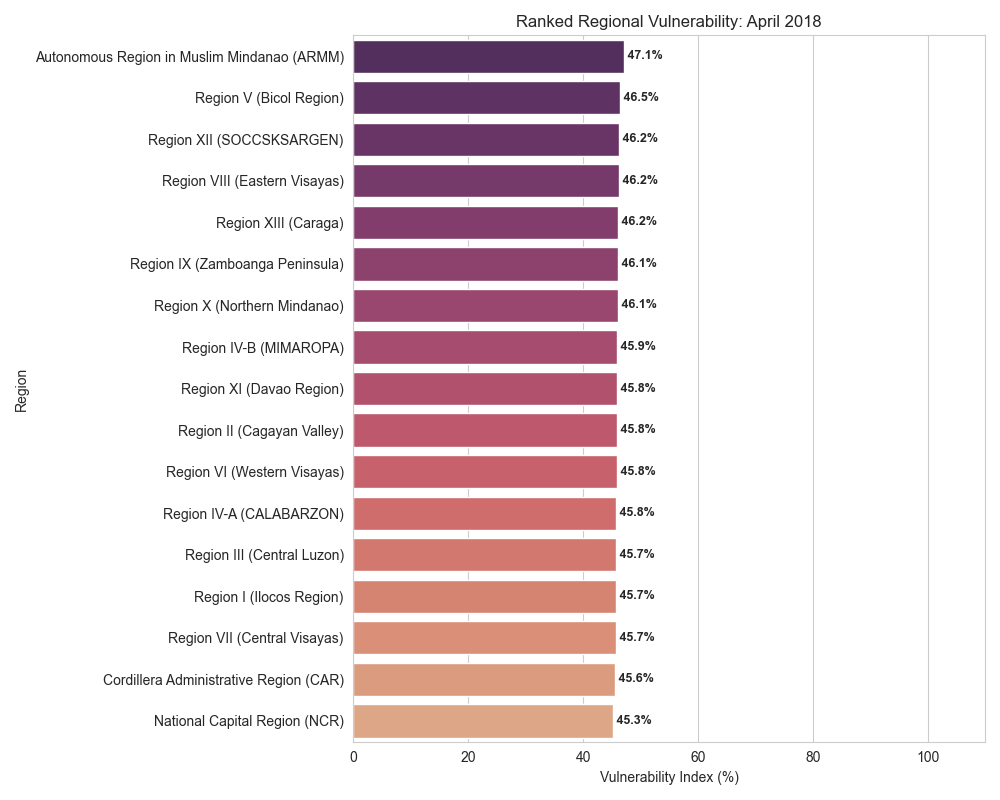

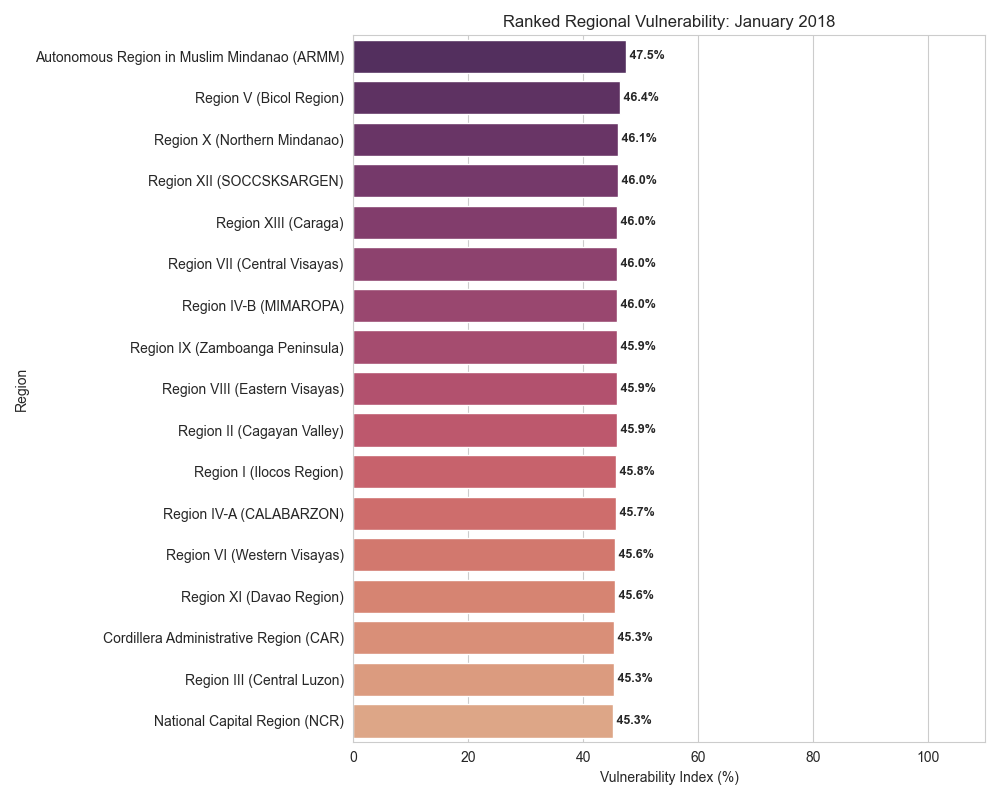

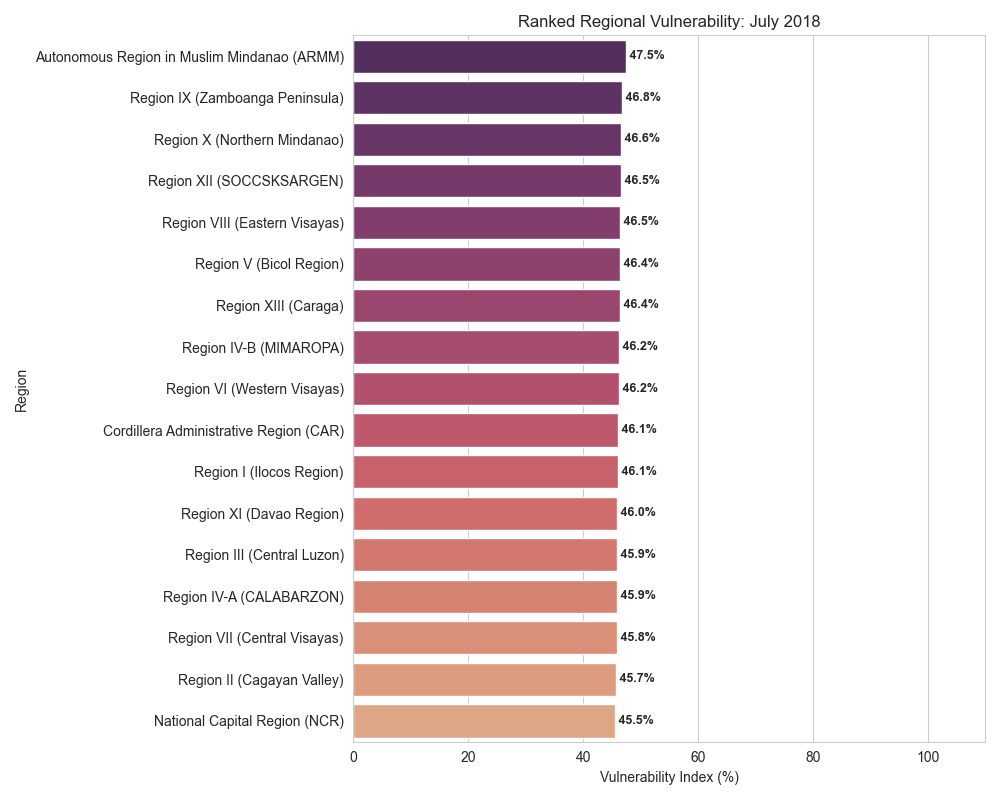

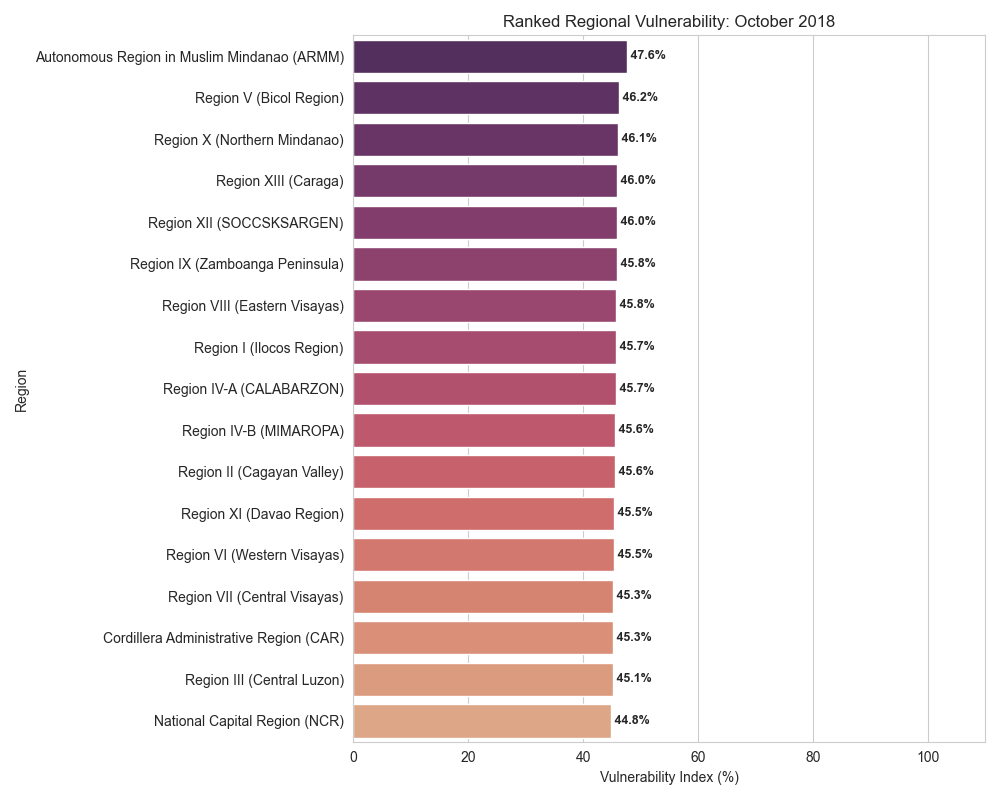

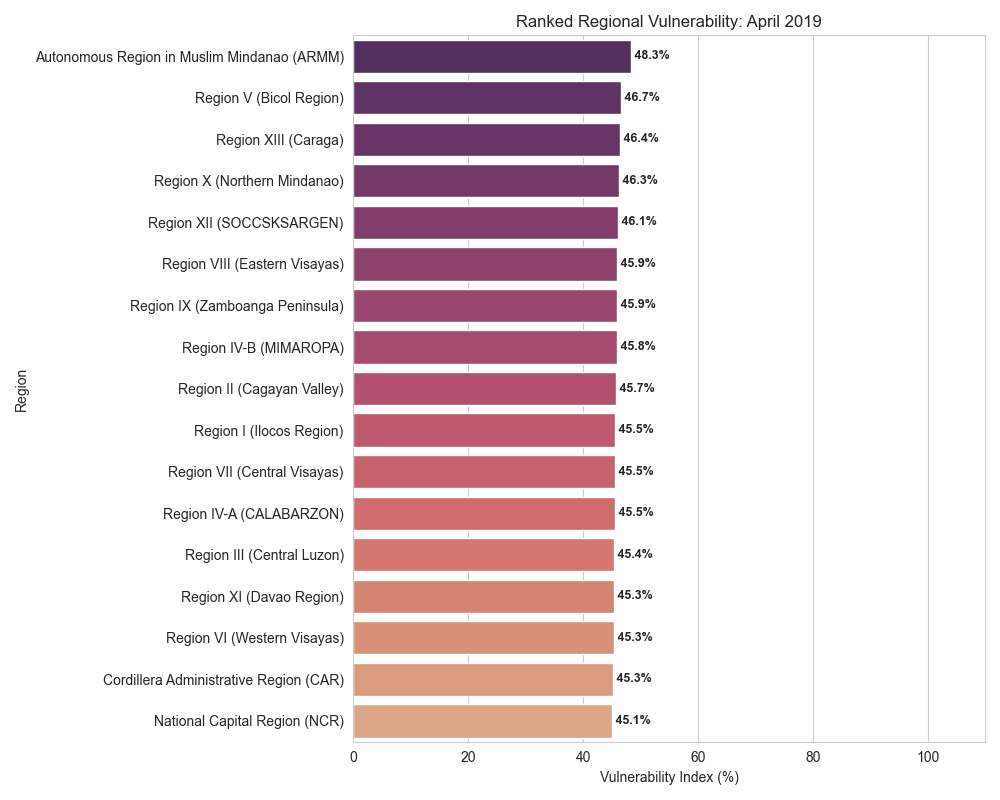

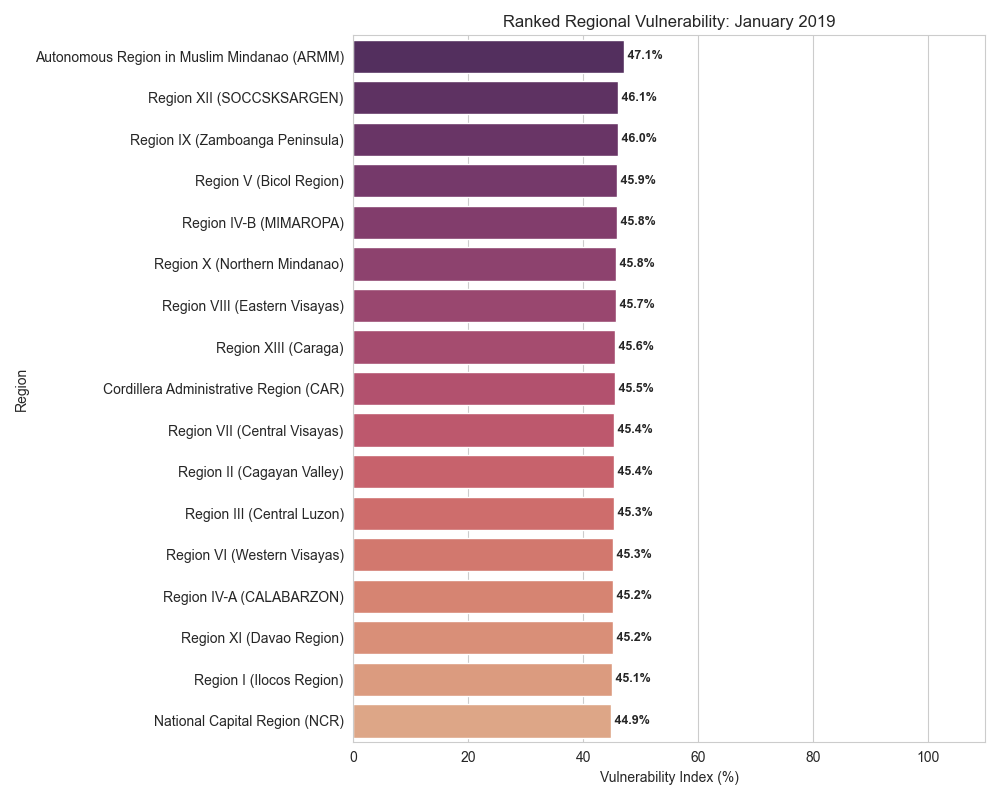

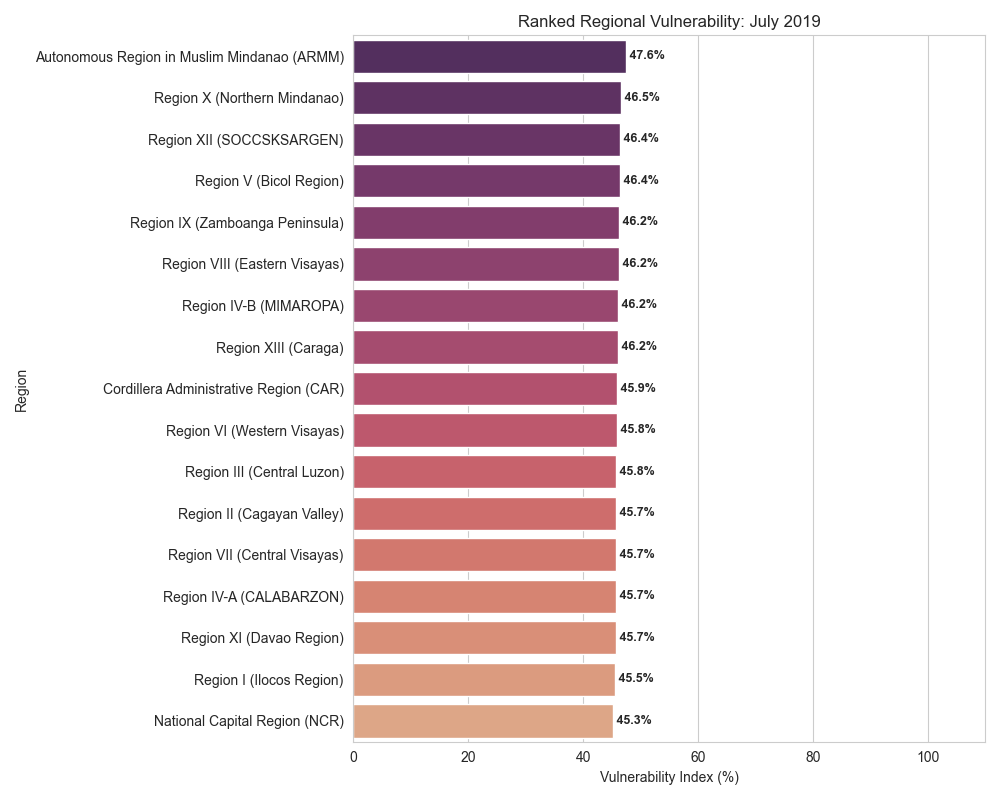

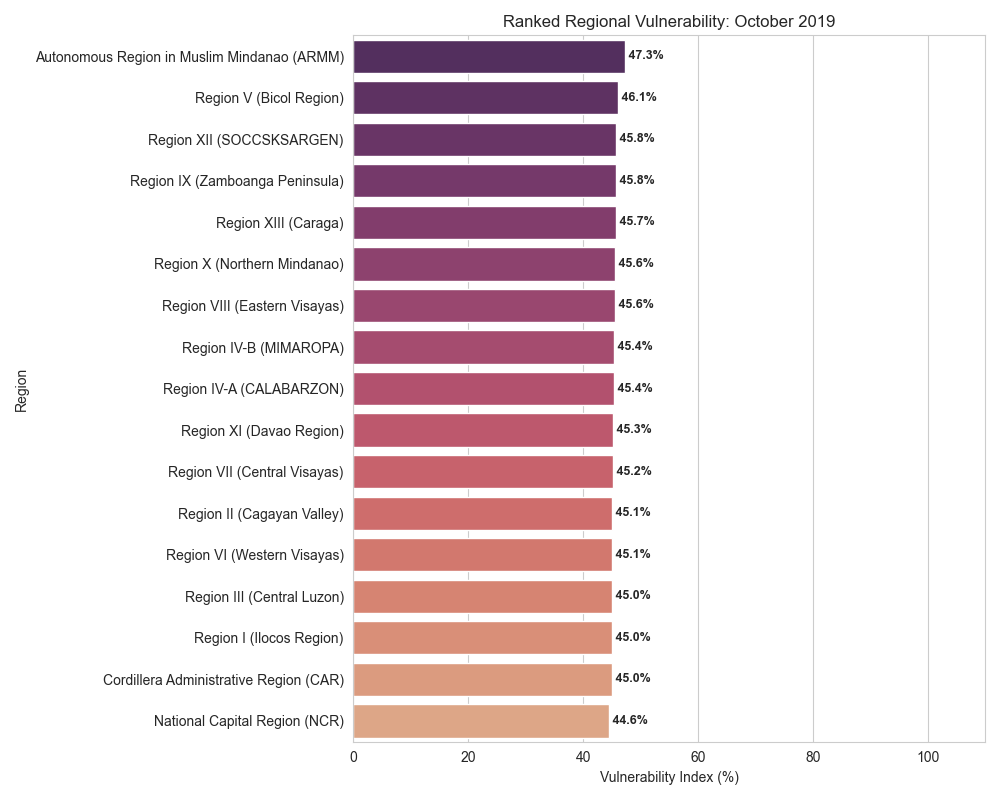

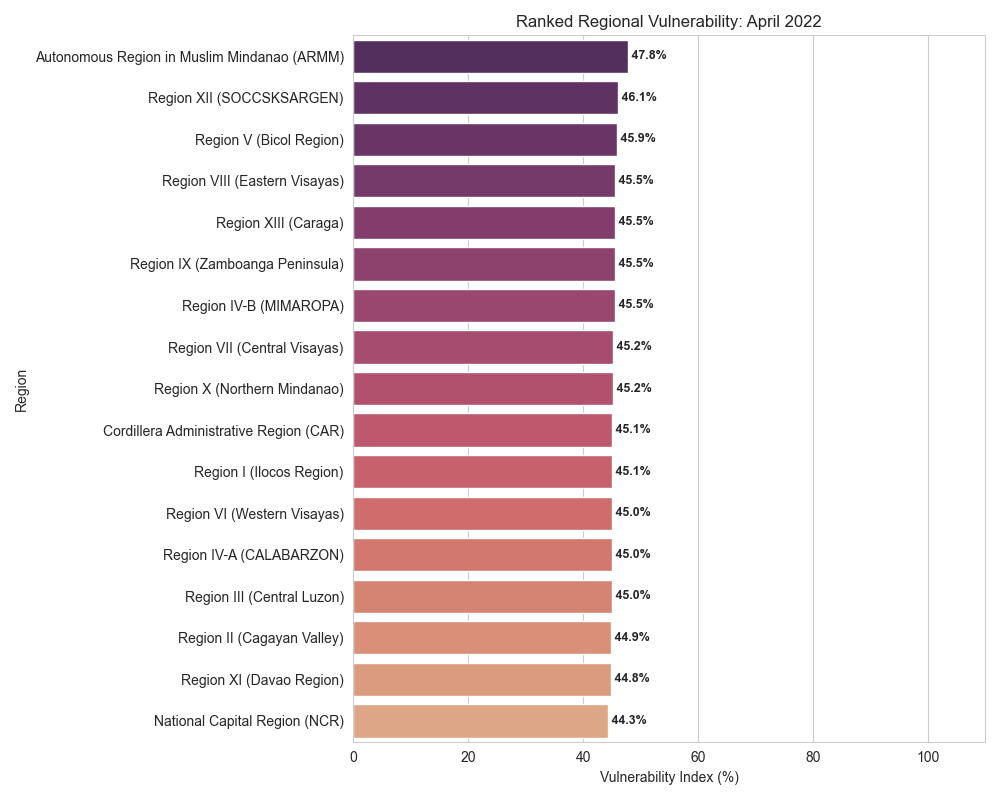

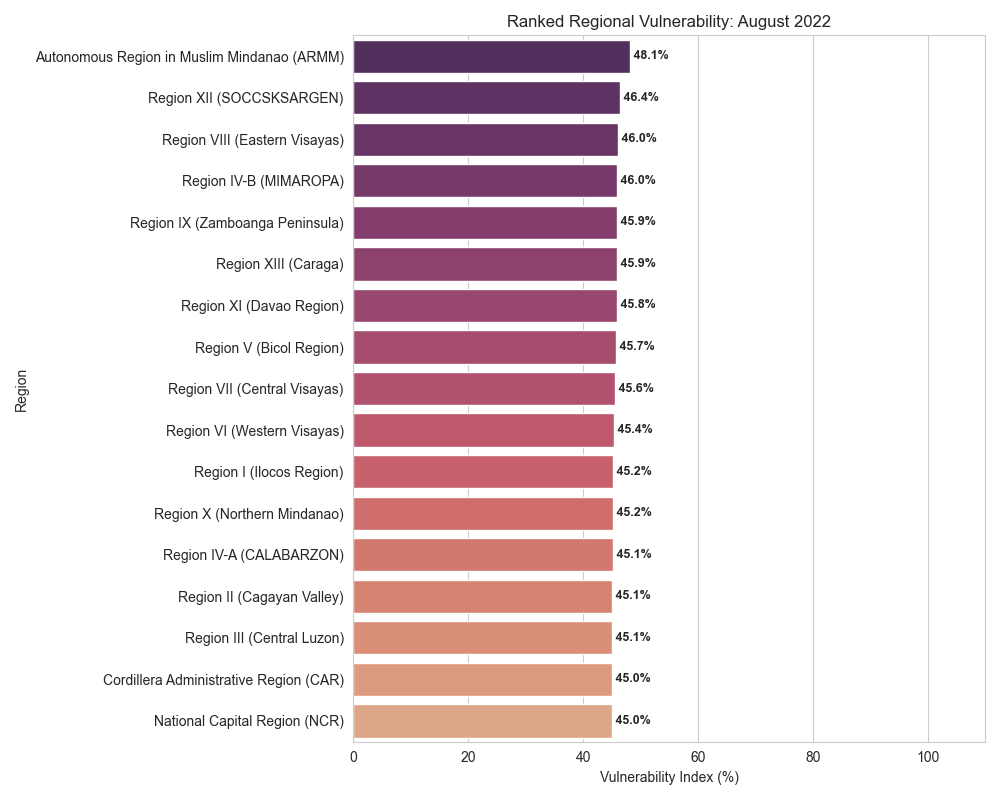

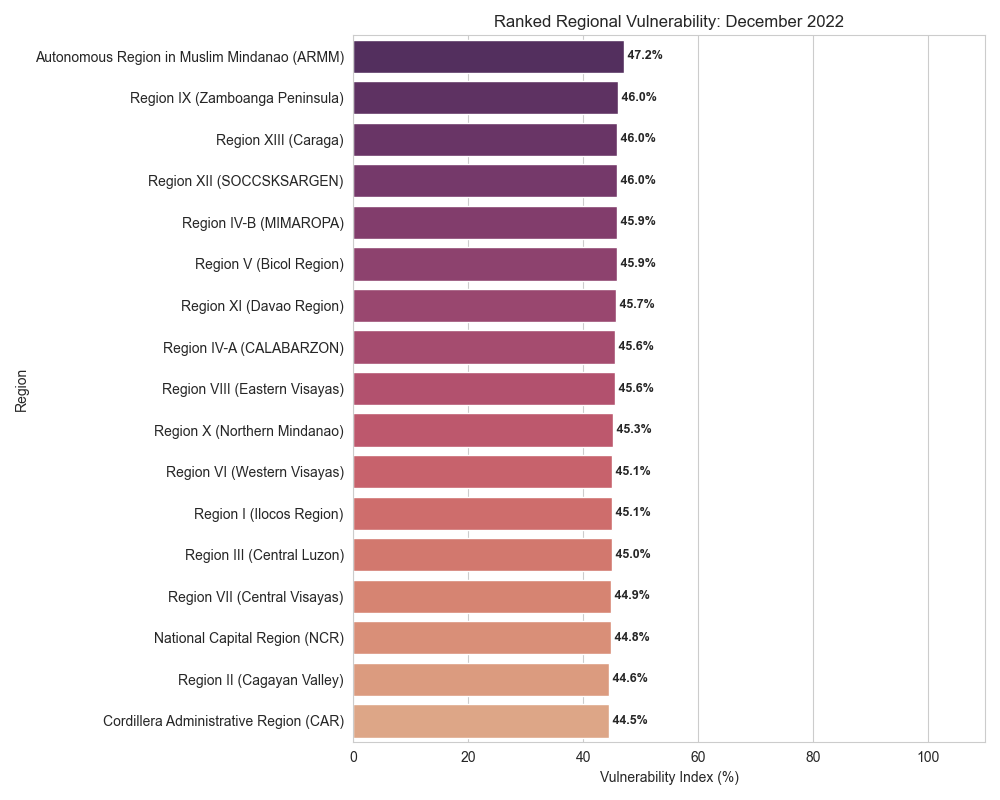

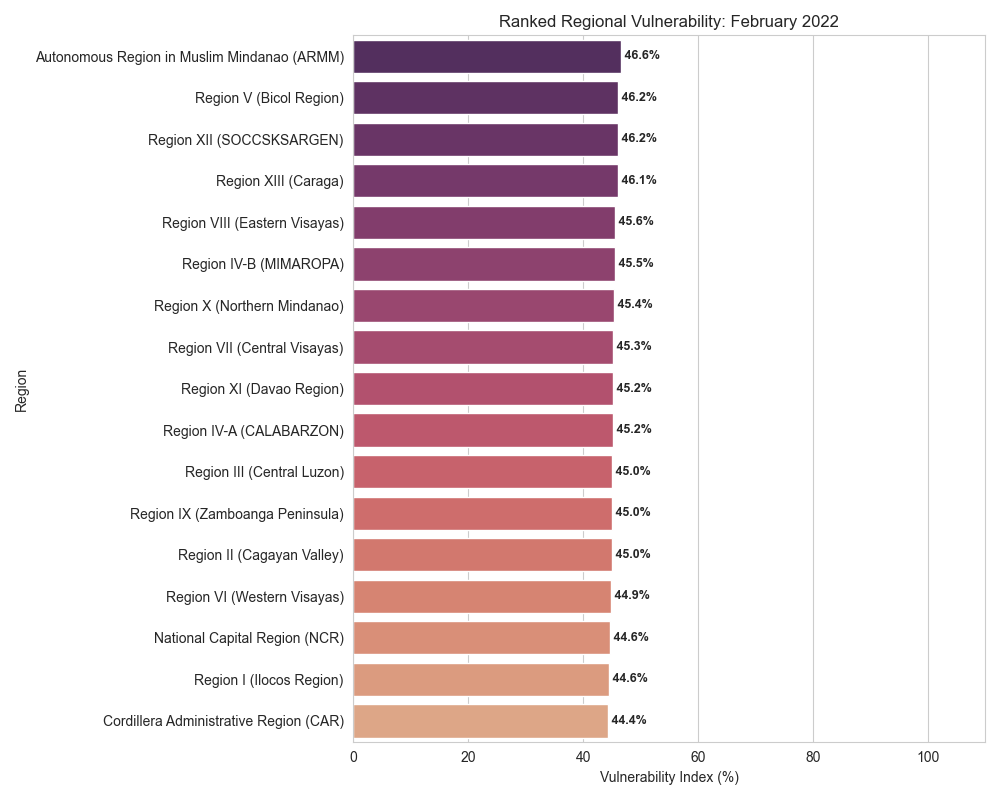

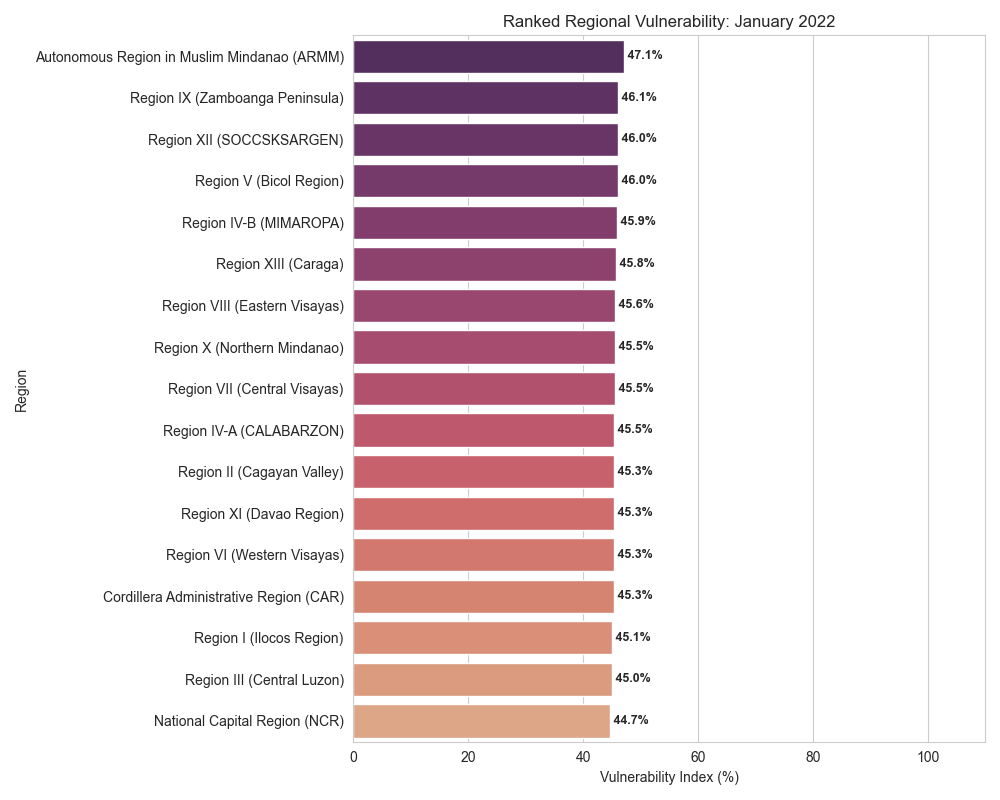

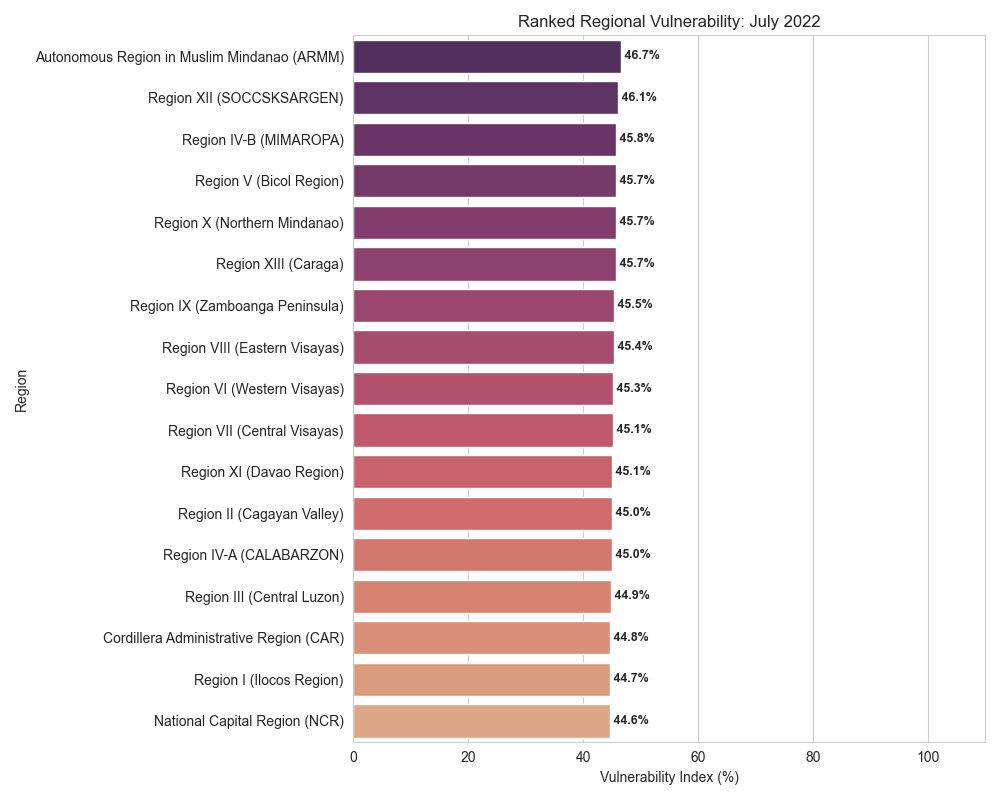

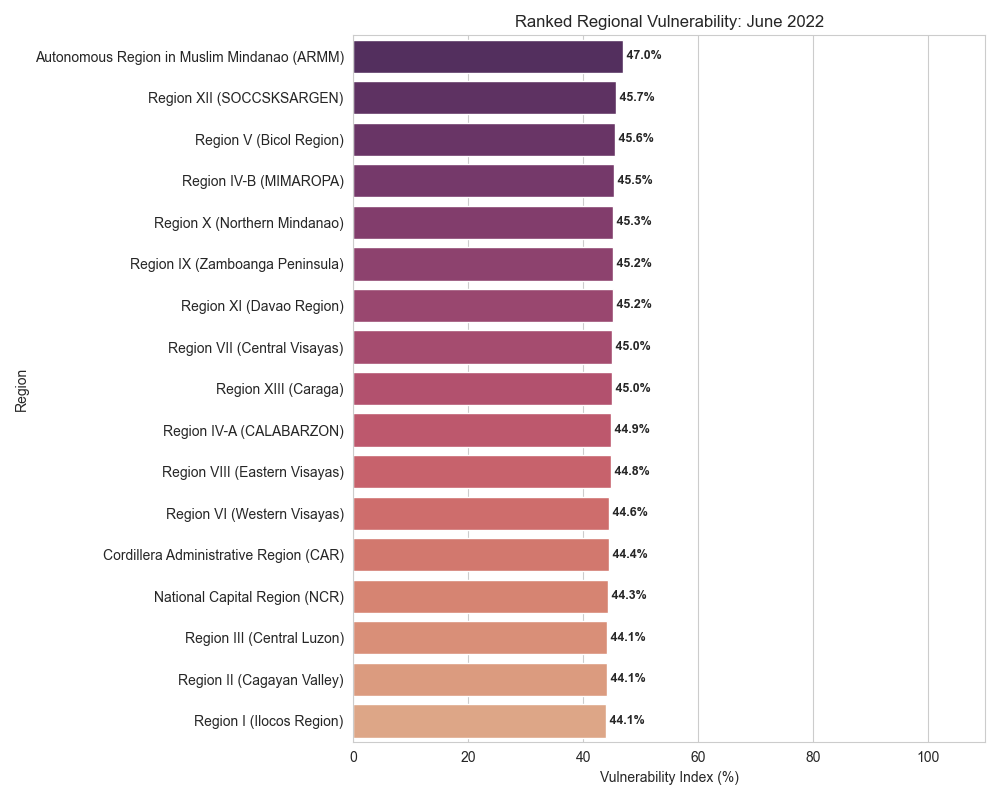

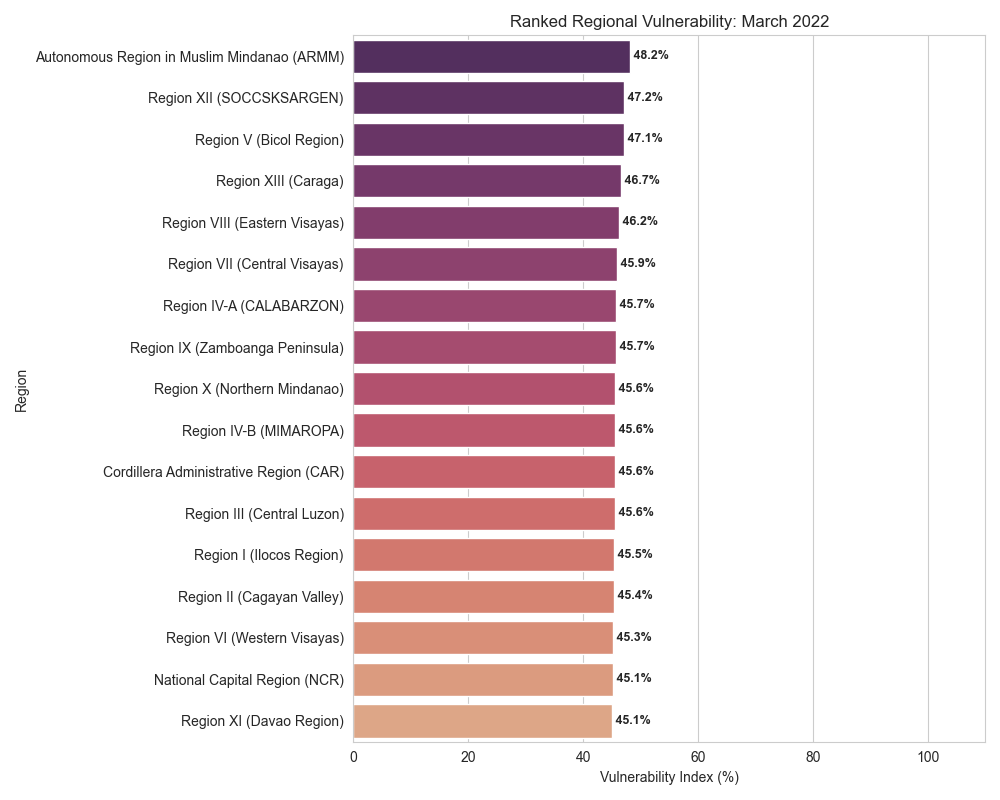

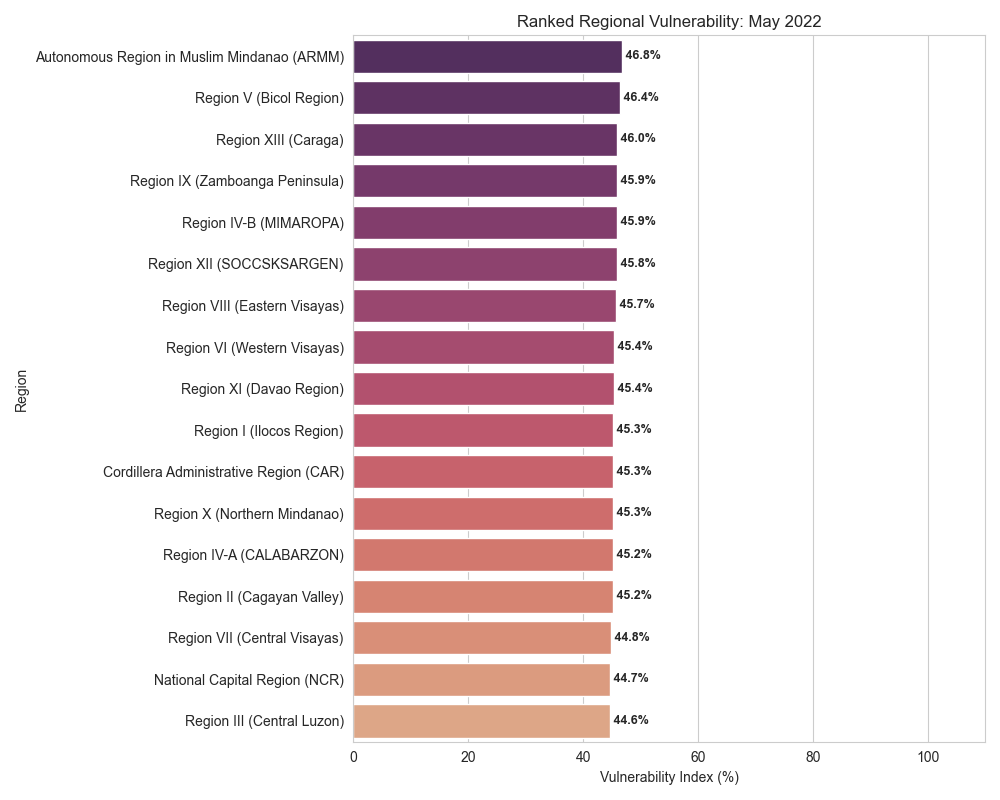

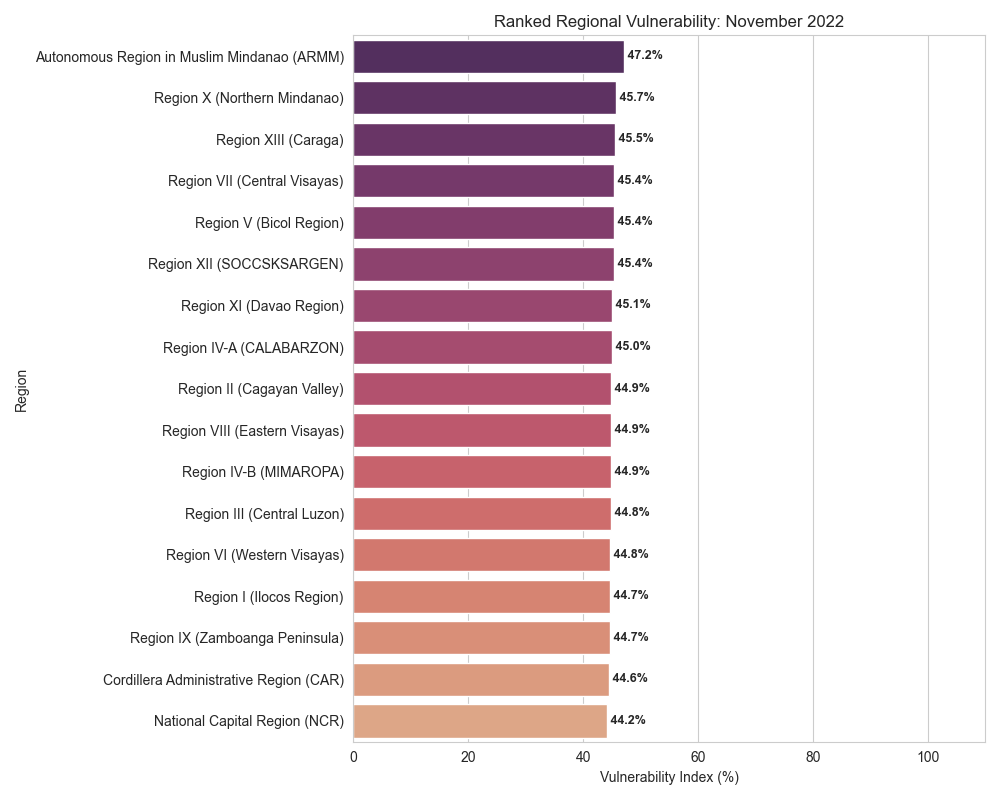

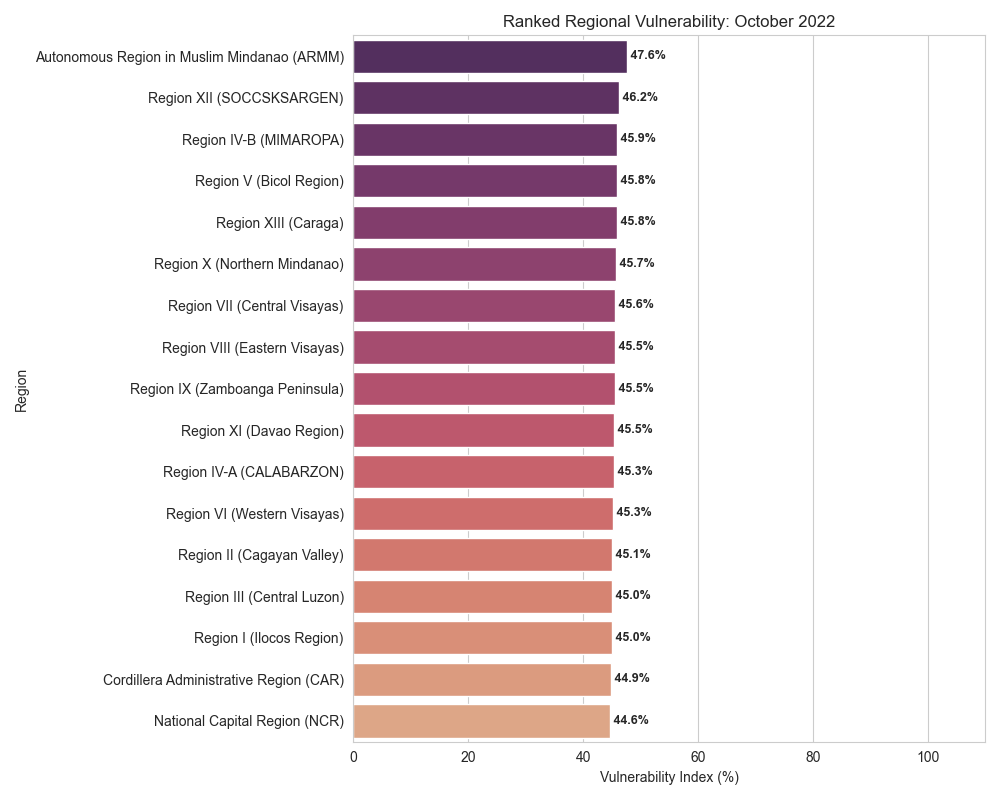

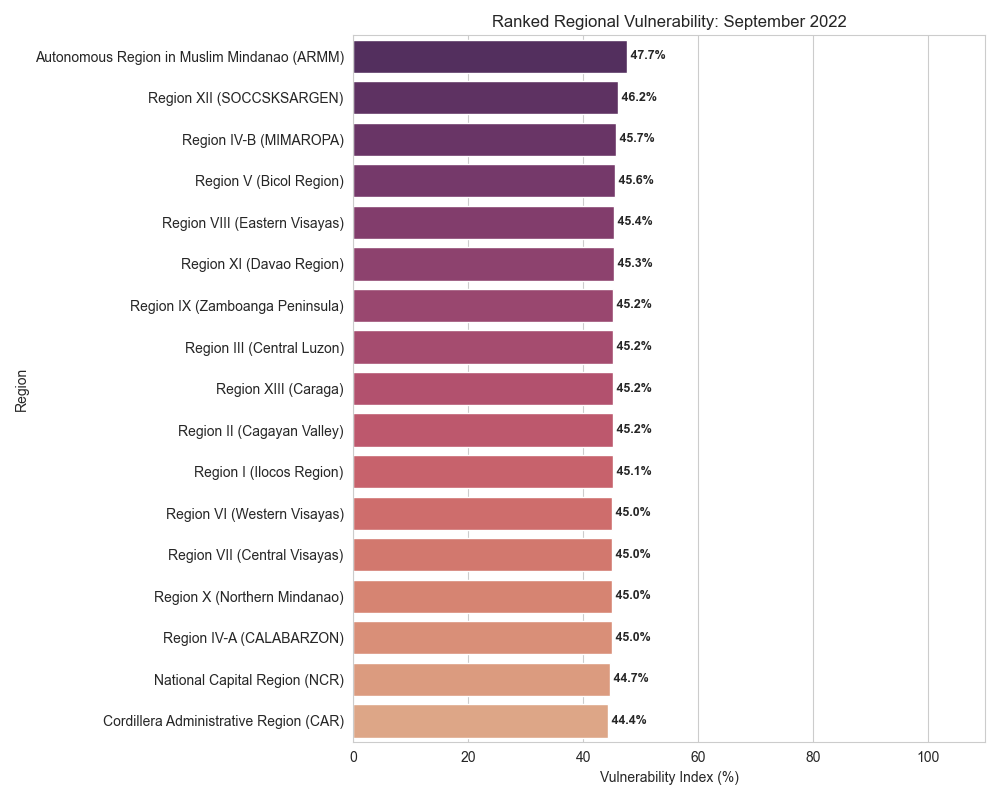

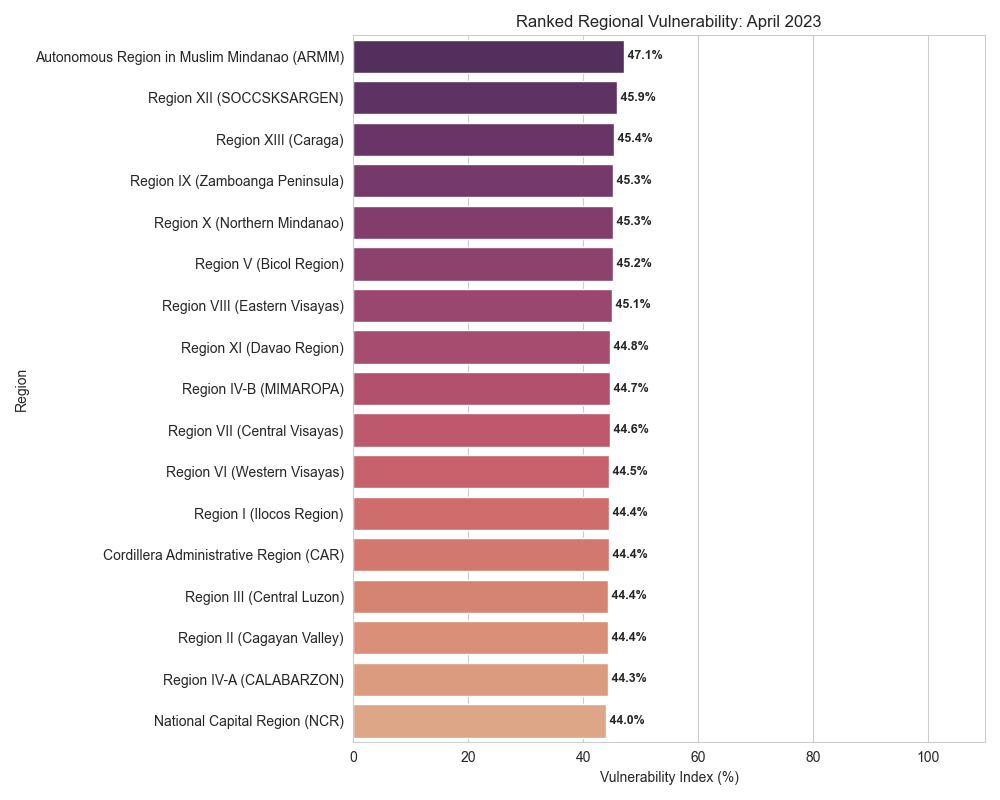

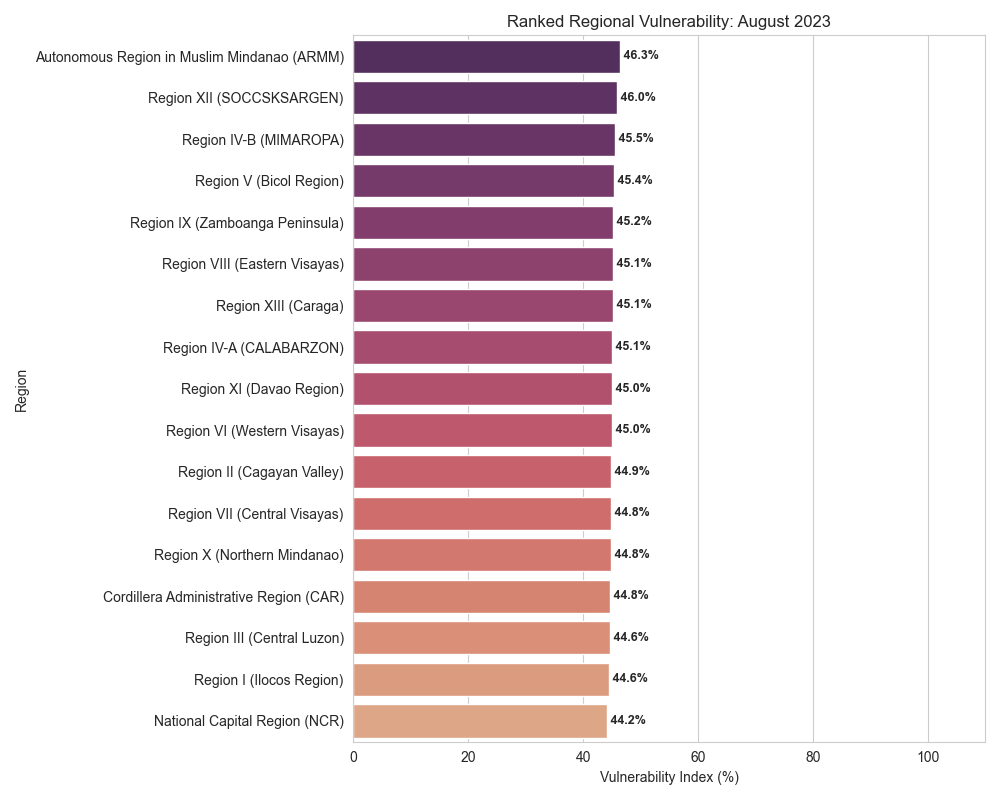

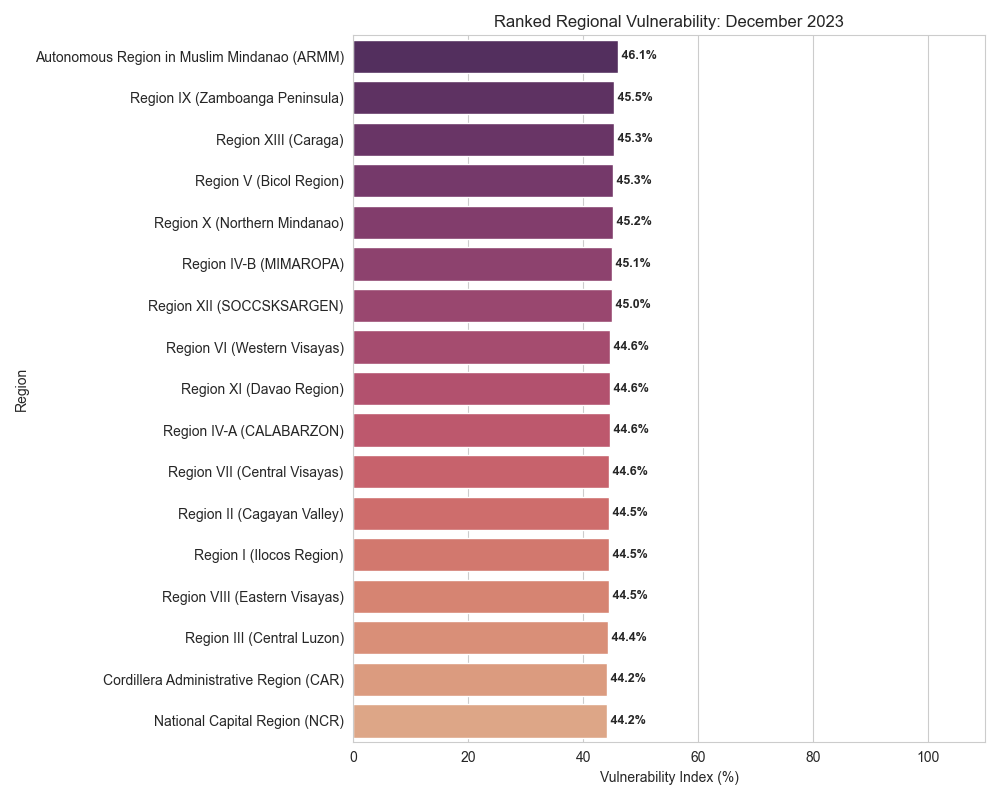

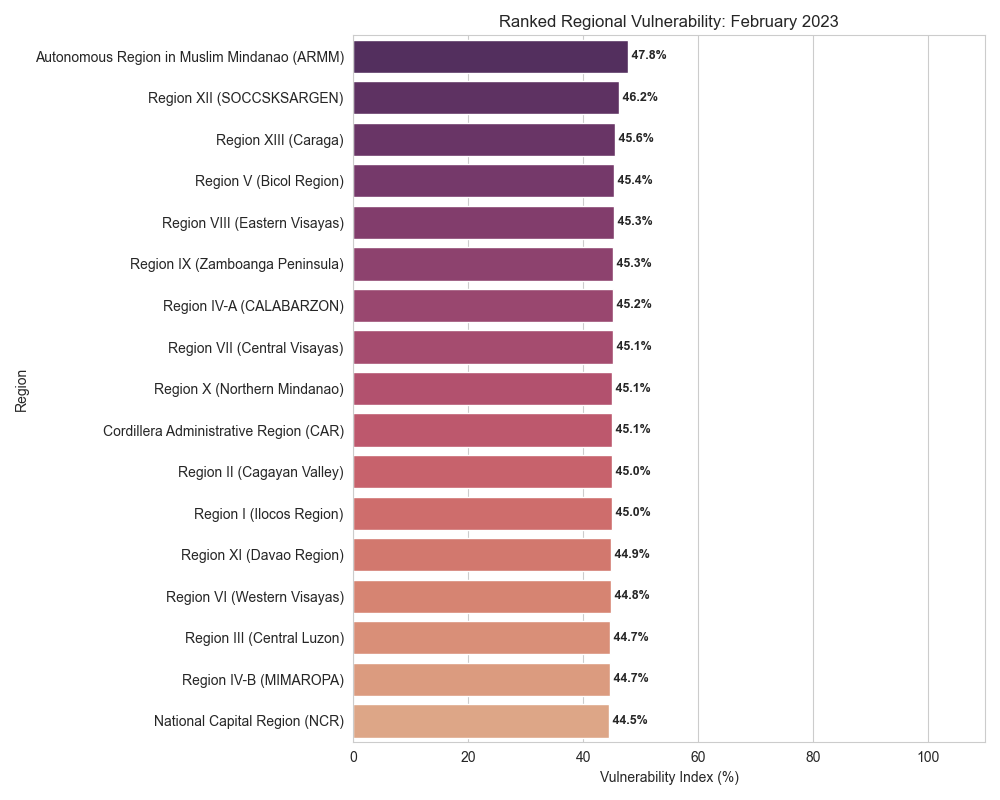

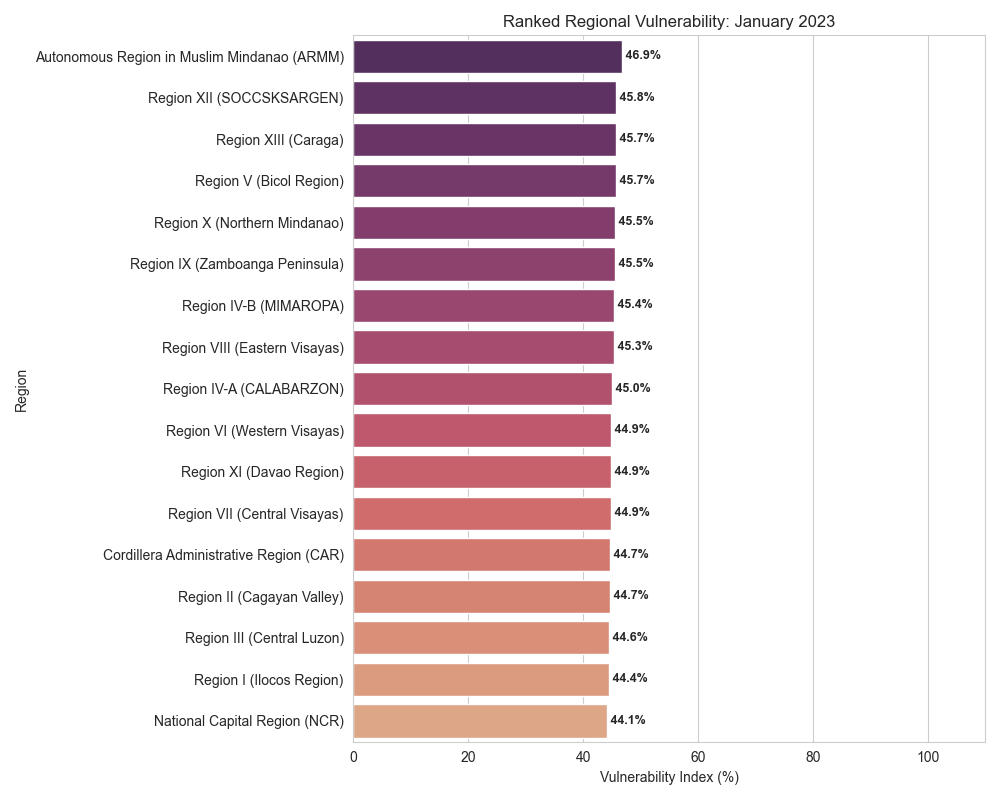

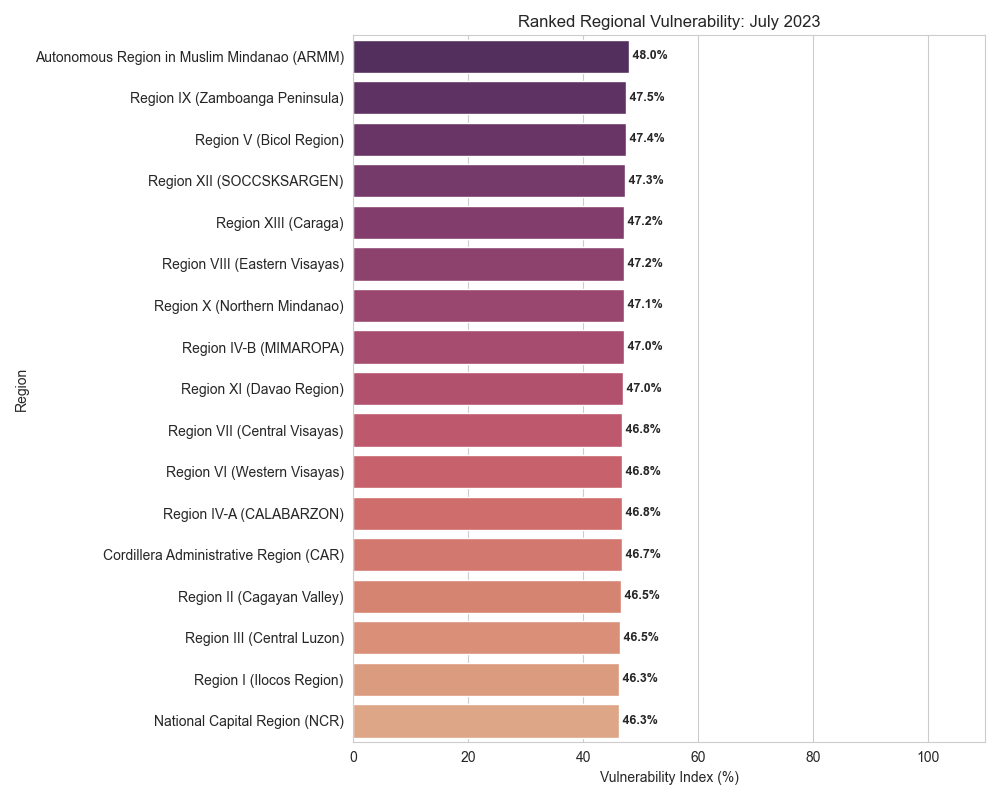

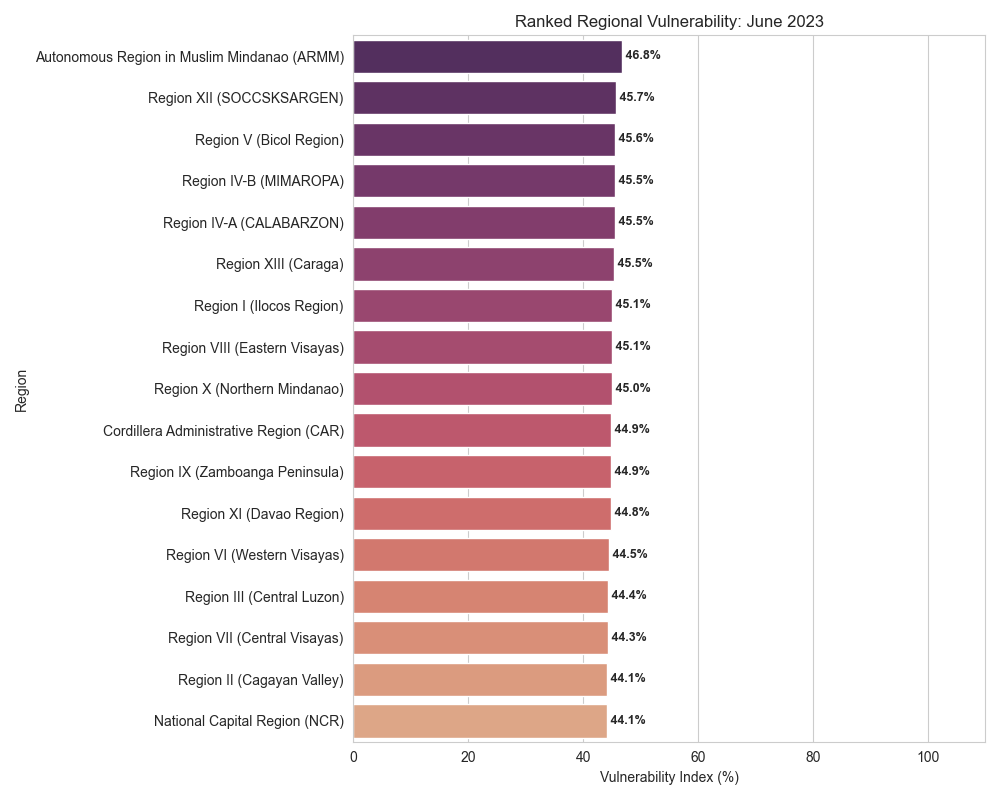

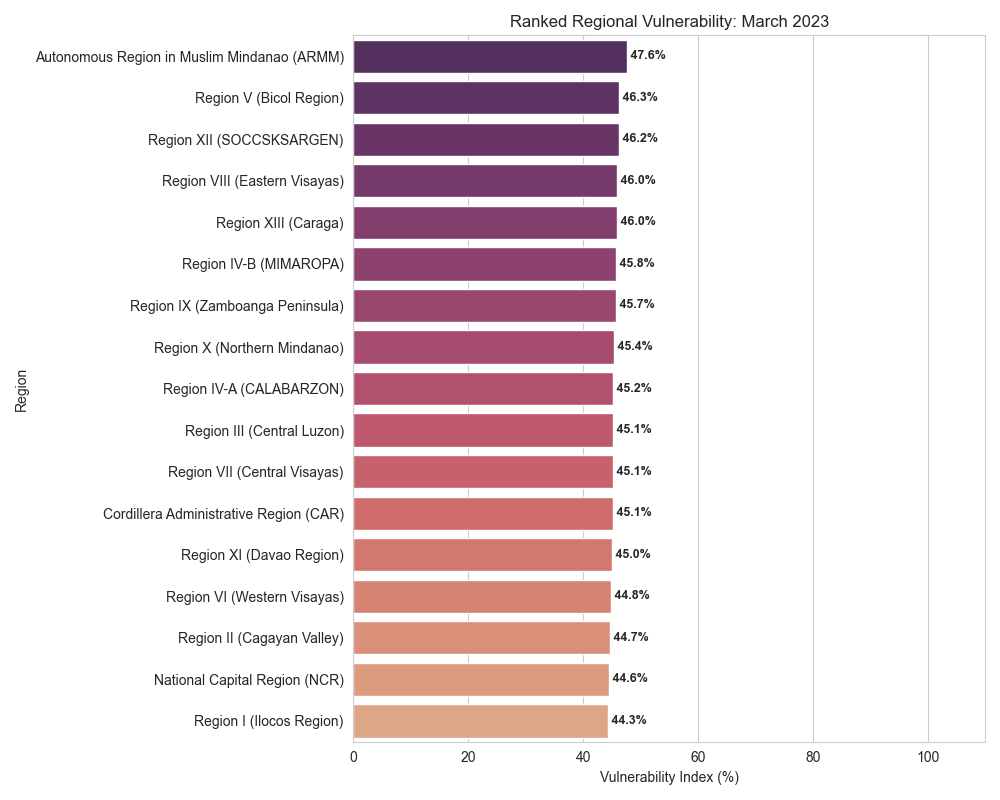

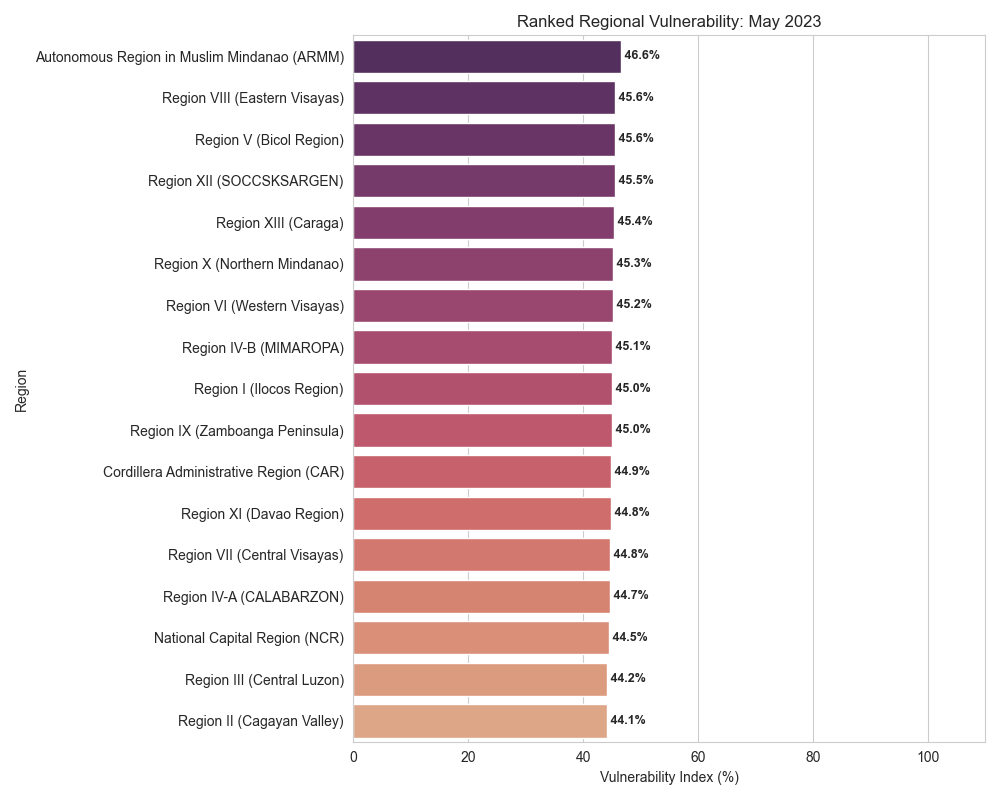

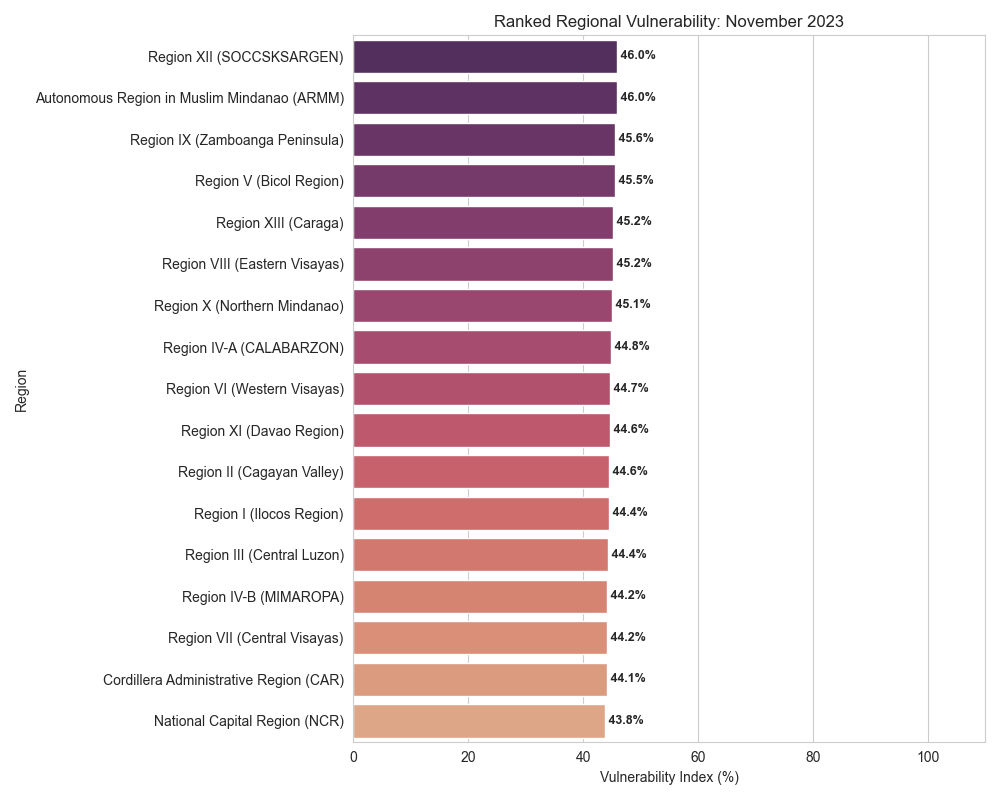

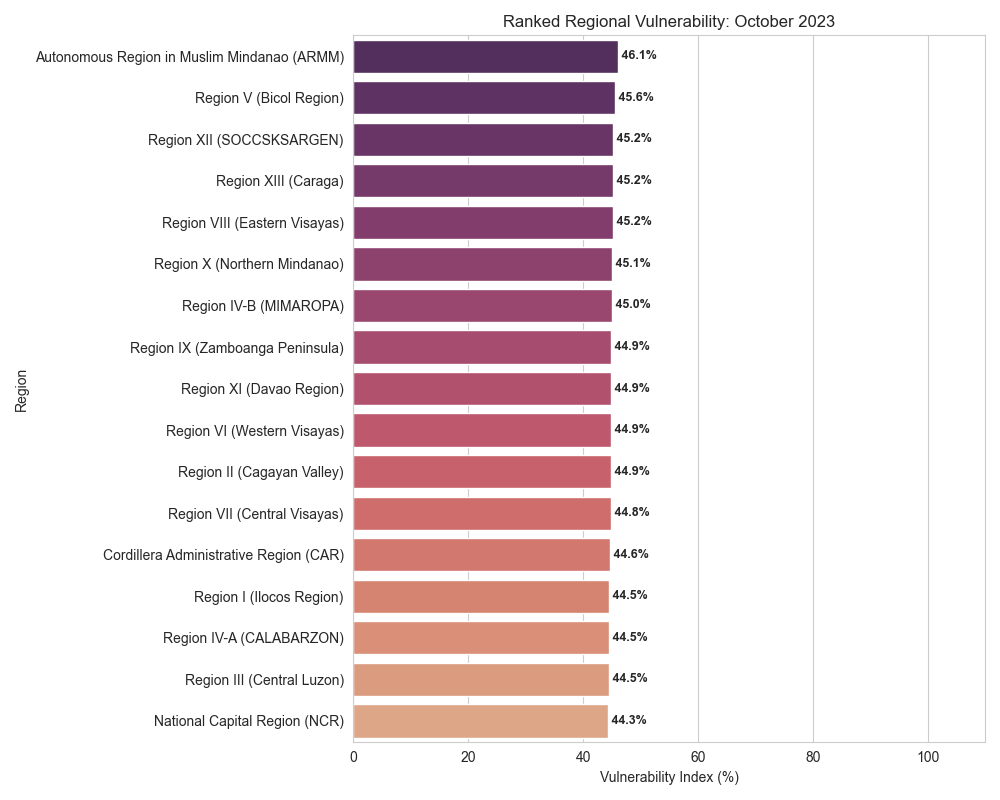

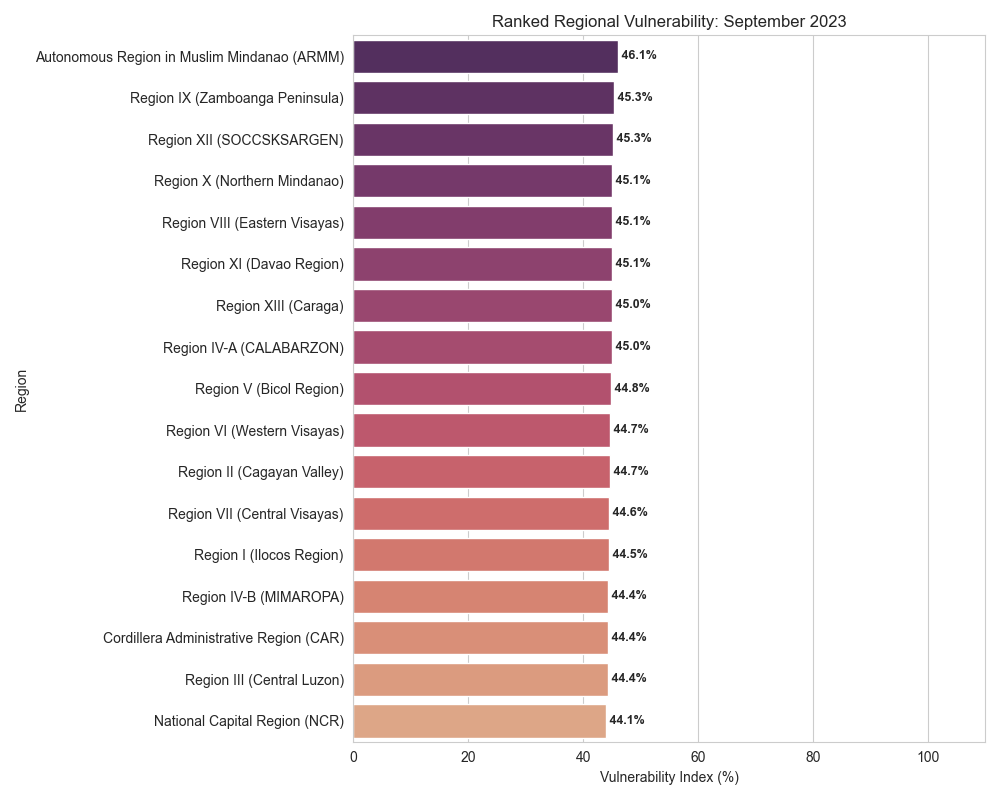

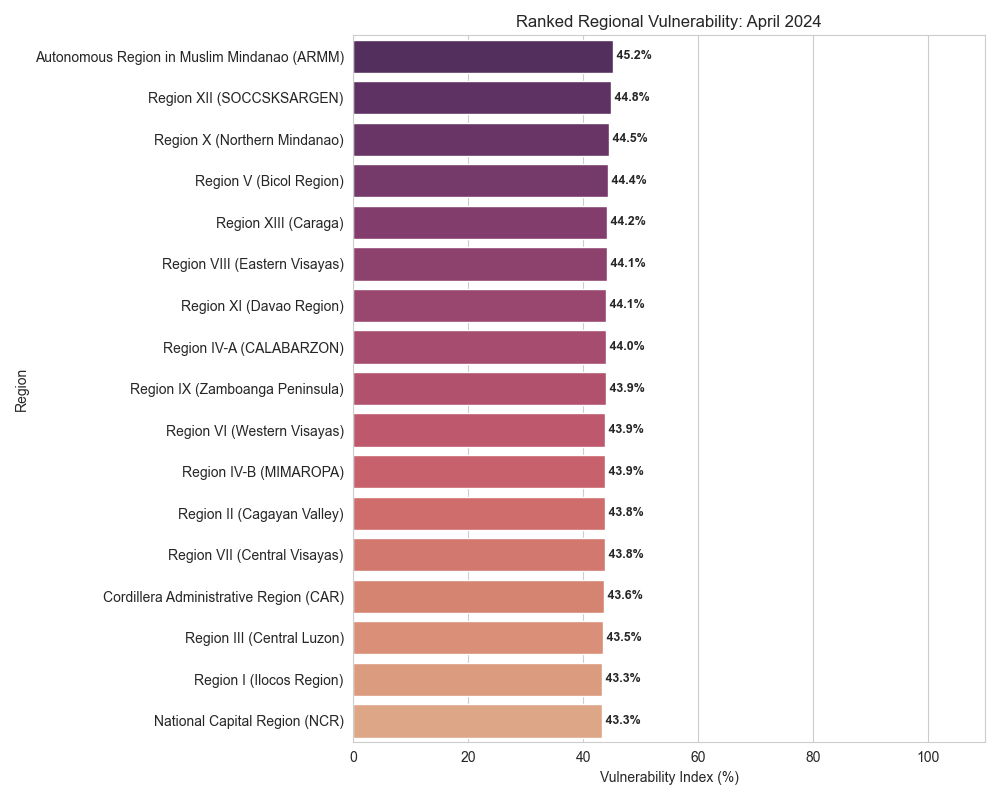

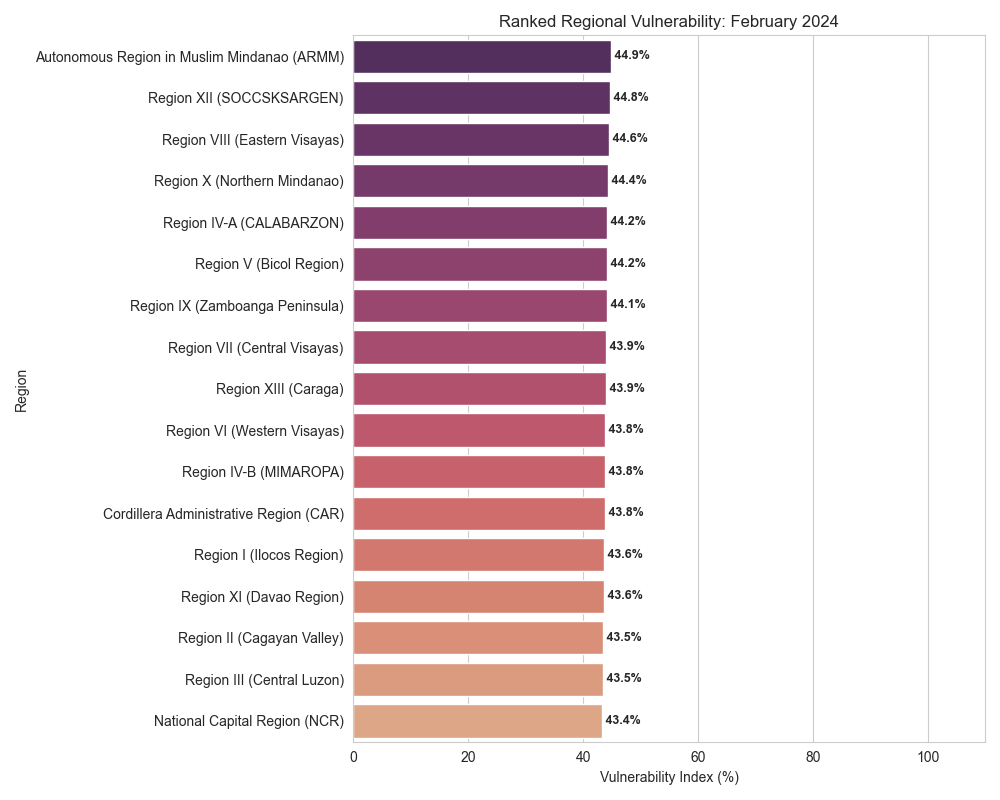

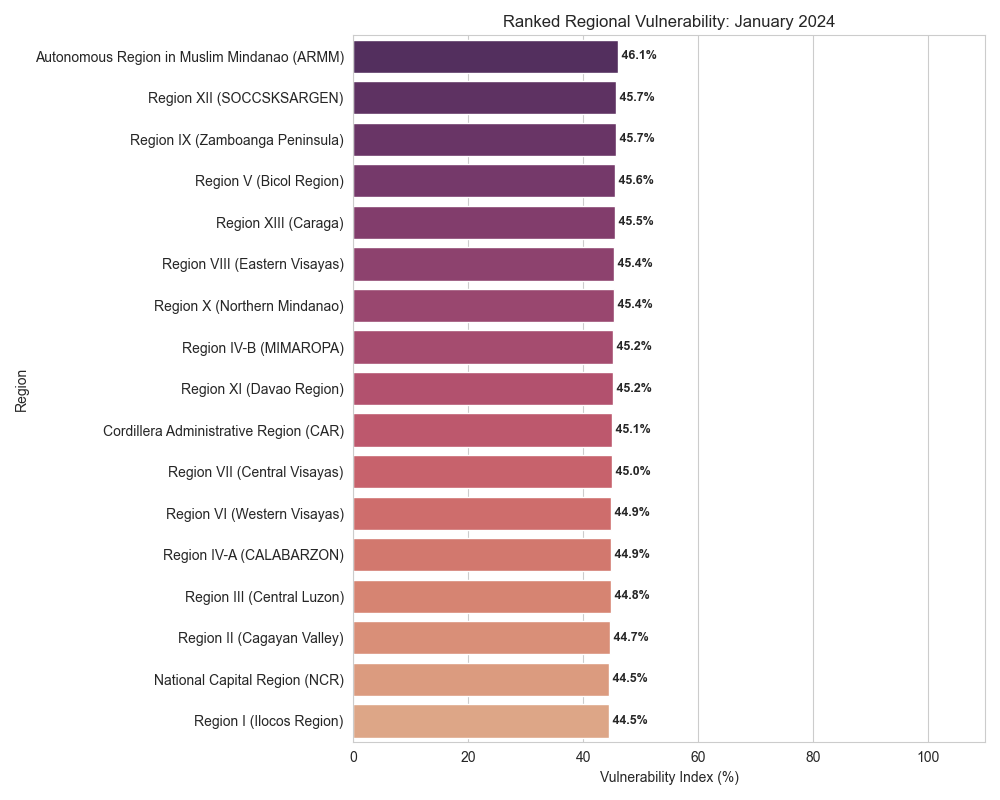

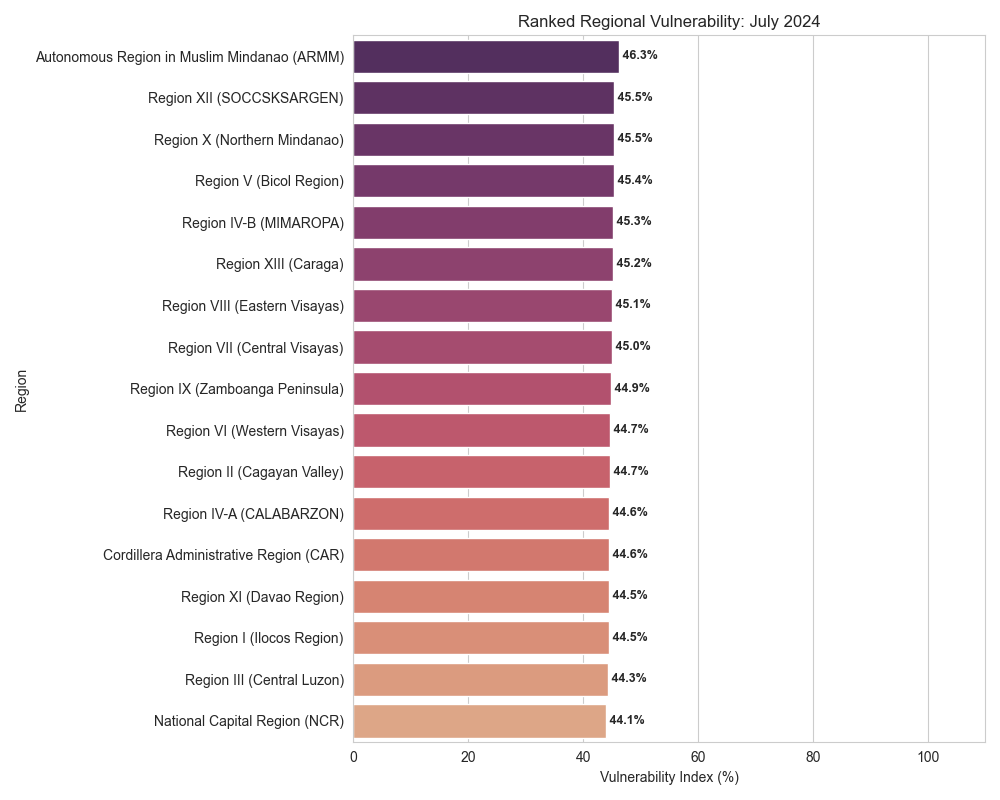

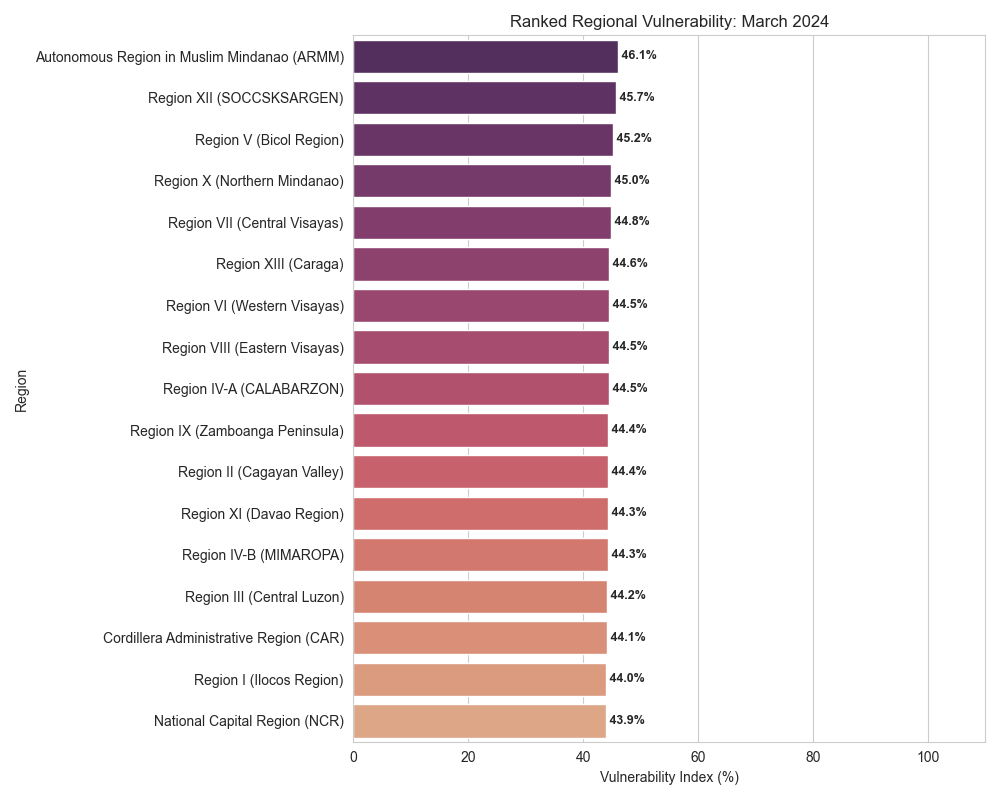


 TASK COMPLETE: All charts processed.


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import gc
from pathlib import Path
from IPython.display import Image, display as ipy_display

# --- 1. SETTINGS & PATHS ---
ENRICHED_SOURCE = BASE_PATH / "FINAL Survey Datasets with Factor Scores and RFVI"
PROCESSED_DIR = Path("./data/processed")
CHECKPOINT_DIR = PROCESSED_DIR / "temp_monthly_stats"
PLOT_OUTPUT_DIR = Path("./plots/monthly_rfvi_bars_horizontal")

SUMMARY_MONTHLY_FILE = PROCESSED_DIR / "rfvi_monthly_summary.csv"
SUMMARY_OVERALL_FILE = PROCESSED_DIR / "rfvi_overall_structural_results.csv"

os.makedirs(CHECKPOINT_DIR, exist_ok=True)
os.makedirs(PLOT_OUTPUT_DIR, exist_ok=True)

# --- 2. PART A: INCREMENTAL AGGREGATION (Chunked Processing) ---
if not SUMMARY_MONTHLY_FILE.exists():
    print(" Incremental Aggregation ...")
    month_folders = sorted([f for f in os.listdir(ENRICHED_SOURCE) if (ENRICHED_SOURCE / f).is_dir()])
    
    for i, folder in enumerate(month_folders):
        checkpoint_path = CHECKPOINT_DIR / f"{folder}.csv"
        
        # Check if we already have the reduced data for this month
        if checkpoint_path.exists():
            print(f"  Skip (Already Aggregated): {folder}".ljust(60), end="\r")
            continue

        folder_path = ENRICHED_SOURCE / folder
        files = list(folder_path.glob("Enriched_*.csv"))
        if not files: continue
        
        # Initialize running totals for this specific month
        running_totals = None
        
        # Process giant file in small bites (50,000 rows at a time)
        for chunk in pd.read_csv(files[0], usecols=['Region', 'RFVI'], chunksize=50000, engine='c'):
            # Aggregate sums and counts within the current chunk
            chunk_stats = chunk.groupby('Region')['RFVI'].agg(['sum', 'count'])
            
            if running_totals is None:
                running_totals = chunk_stats
            else:
                running_totals = running_totals.add(chunk_stats, fill_value=0)
            
            del chunk
            gc.collect()

        # Compute the final mean from the accumulated totals
        monthly = (running_totals['sum'] / running_totals['count']).reset_index()
        monthly.columns = ['Region', 'RFVI']
        
        parts = folder.split('_')
        monthly['Year'], monthly['Month'], monthly['Period'] = parts[0], parts[1], folder
        
        # Save the reduced result for this month
        monthly.to_csv(checkpoint_path, index=False)
        
        del running_totals
        del monthly
        gc.collect() 
        
        print(f"  Aggregated {i+1}/{len(month_folders)}: {folder}".ljust(60), end="\r")

    # Merge all small monthly summaries into the Master Summary
    print("\n Finalizing Master Monthly Summary...")
    checkpoint_files = list(CHECKPOINT_DIR.glob("*.csv"))
    df_monthly_summary = pd.concat([pd.read_csv(f) for f in checkpoint_files], ignore_index=True)
    df_monthly_summary.to_csv(SUMMARY_MONTHLY_FILE, index=False)
    
    # Compute General Means (Mean of Means) for the Headline Results
    df_overall = df_monthly_summary.groupby('Region')['RFVI'].mean().reset_index()
    df_overall = df_overall.sort_values('RFVI', ascending=False)
    df_overall.to_csv(SUMMARY_OVERALL_FILE, index=False)
    print(" SUCCESS: Summary Data Prepared.")

# --- 3. PART B: SMART GALLERY LOAD ---
print("\n GENERATING NOTEBOOK GALLERY...")
if SUMMARY_MONTHLY_FILE.exists():
    summary_df = pd.read_csv(SUMMARY_MONTHLY_FILE)
    periods = sorted(summary_df['Period'].unique())

    for period in periods:
        row_data = summary_df[summary_df['Period'] == period].iloc[0]
        file_path = PLOT_OUTPUT_DIR / f"RFVI_Ranked_{row_data['Year']}_{row_data['Month']}.png"

        if file_path.exists():
            # If the chart image exists, show it immediately from the disk
            ipy_display(Image(filename=file_path))
        else:
            # If image is missing, render it now
            monthly_data = summary_df[summary_df['Period'] == period].copy()
            monthly_data['RFVI_pct'] = monthly_data['RFVI'] * 100
            monthly_data = monthly_data.sort_values('RFVI_pct', ascending=False)

            plt.figure(figsize=(10, 8))
            sns.set_style("whitegrid")
            ax = sns.barplot(data=monthly_data, x='RFVI_pct', y='Region', palette='flare_r', hue='Region', legend=False)
            
            for p in ax.patches:
                ax.annotate(f' {p.get_width():.1f}%', (p.get_width(), p.get_y() + p.get_height()/2.), 
                            ha='left', va='center', fontsize=9, fontweight='bold')

            plt.title(f"Ranked Regional Vulnerability: {row_data['Month']} {row_data['Year']}")
            plt.xlabel("Vulnerability Index (%)")
            plt.xlim(0, 110)
            plt.tight_layout()
            plt.savefig(file_path, dpi=100)
            plt.show()
            plt.close('all')
            gc.collect()
else:
    print(" Error: Monthly summary file missing.")

print("\n TASK COMPLETE: All charts processed.")

Key Insight:

- Rankings **vary across months**, indicating that regional vulnerability is not static but responds to time-specific economic and structural conditions.
- Some regions may consistently appear in higher or lower positions, while others shift significantly between survey rounds.

Implication:

Regional financial vulnerability exhibits temporal fluctuations. The changing rankings highlight short-term shocks or adjustments, while repeated high or low placements may indicate persistent vulnerability or resilience.

These monthly visualizations therefore support:
- Temporal monitoring of regional vulnerability trends
- Identification of regions with recurring high vulnerability
- Differentiation between temporary spikes and long-term risk

---
### Overall RFVI Ranking (2018-2024)

After generating the RFVI ranking across survey months, the final overall RFVI ranking across all regions is also computed.

The overall RFVI visualization:
- Ranks regions from most to least vulnerable by mean RFVI
- Displays percentage of RFVI values

This provides an **overall financial vulnerability ranking across time.**

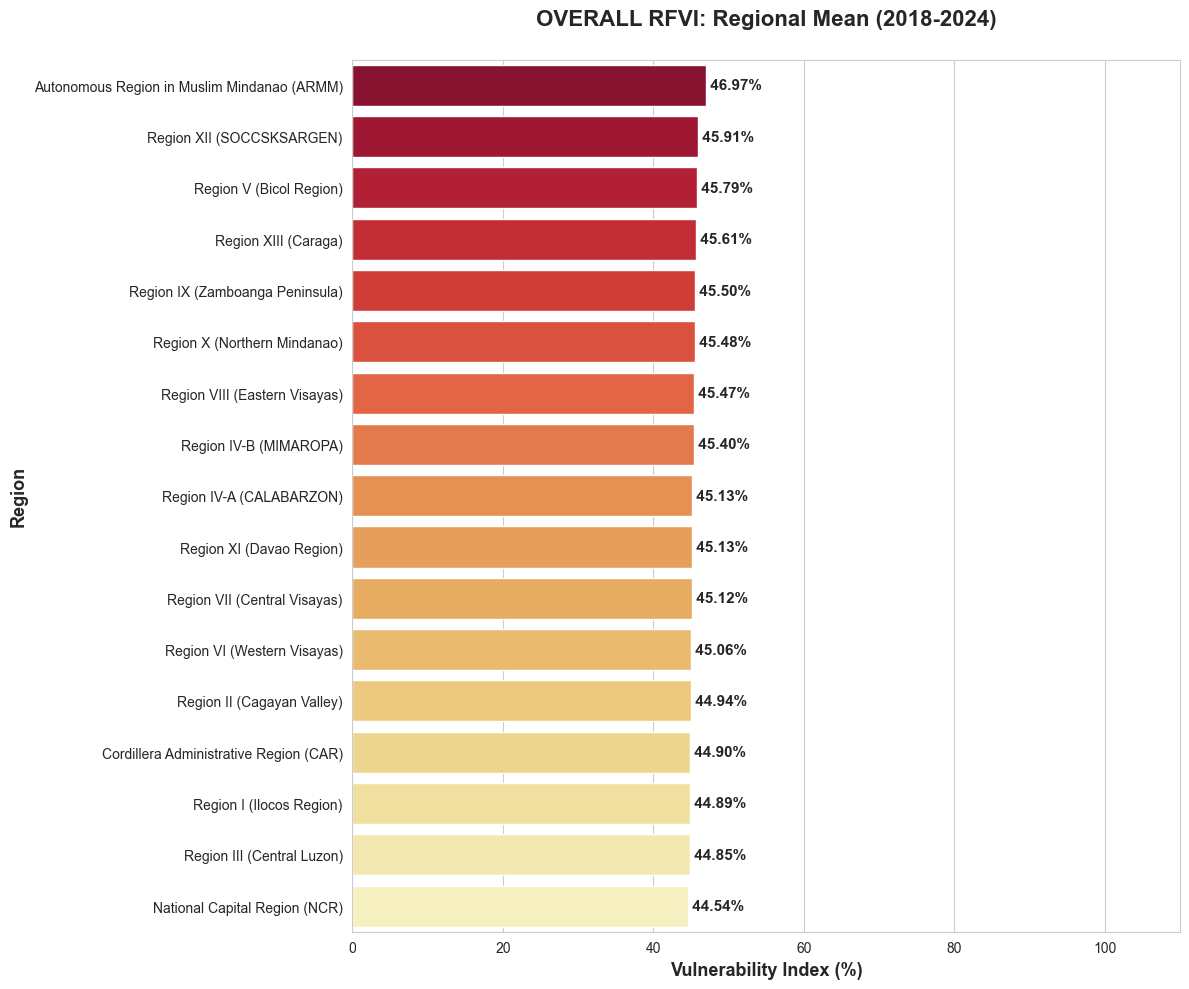

 Structural Chart saved to: plots\OVERALL_STRUCTURAL_RANKING.png


In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# --- 1. CONFIGURATION ---
OVERALL_FILE = Path("./data/processed/rfvi_overall_structural_results.csv")
OUTPUT_PATH = Path("./plots/OVERALL_STRUCTURAL_RANKING.png")

# --- 2. LOAD & PREPARE ---
if OVERALL_FILE.exists():
    df_overall = pd.read_csv(OVERALL_FILE)
    
    # Sort: Highest Vulnerability at the top
    df_overall = df_overall.sort_values('RFVI', ascending=False)
    df_overall['RFVI_pct'] = df_overall['RFVI'] * 100
    
    # --- 3. VISUALIZE ---
    plt.figure(figsize=(12, 10))
    sns.set_style("whitegrid")
    
    ax = sns.barplot(
        data=df_overall, 
        x='RFVI_pct', 
        y='Region', 
        palette='YlOrRd_r', 
        hue='Region', 
        legend=False
    )
    
    # Add Bold Data Labels
    for p in ax.patches:
        width = p.get_width()
        ax.annotate(f' {width:.2f}%', 
                    (width, p.get_y() + p.get_height() / 2.), 
                    ha='left', va='center', fontsize=11, fontweight='bold')

    # Titles and Labels
    plt.title("OVERALL RFVI: Regional Mean (2018-2024)", fontsize=16, pad=25, fontweight='bold')
    plt.xlabel("Vulnerability Index (%)", fontsize=13, fontweight='semibold')
    plt.ylabel("Region", fontsize=13, fontweight='semibold')
    
    # Standardize X-axis
    plt.xlim(0, 110) 
    plt.tight_layout()
    
    # --- 4. SAVE ---
    OUTPUT_PATH.parent.mkdir(parents=True, exist_ok=True)
    plt.savefig(OUTPUT_PATH, dpi=300) 
    plt.show()
    
    print(f" Structural Chart saved to: {OUTPUT_PATH}")

else:
    print(f" Error: {OVERALL_FILE} not found.")

Key Insight:

- When averaged from 2018 to 2024, **ARMM has the highest financial vulnerability (46.97%)**, followed by Region XII (SOCCSKSARGEN) and Region V (Bicol Region).
- **NCR has the lowest average vulnerability (44.54%)**, meaning households there are generally tend to be financially vulnerable compared to other regions.
- The difference between the highest and lowest regions is small (about 2.4 percentage points), showing that financial vulnerability exists across the country, but some regions are more affected than others.
- Many Mindanao regions appear near the top of the list, suggesting that households in these areas tend to face greater financial challenges over time.

Implication:

This ranking shows the **overall pattern from 2018 to 2024**, not just one survey period.

Although monthly rankings change, this long-term average helps identify:
- Regions that consistently face higher financial vulnerability
- Regions that tend to have more stable financial conditions

Regions at the top likely experience more frequent income risk, weaker financial buffers, or greater exposure to shocks.

Regions at the bottom, such as NCR and Central Luzon, generally show stronger financial conditions across survey periods.

---
### Regional Vulnerability SRE Distribution (2018-2024)

After constructing the RFVI, the three pillars are aggregated at the regional level to identify the **structural drivers of vulnerability**.

The process:
- Reconstructs regional averages from monthly datasets containing SRE scores and RFVI
- Computes overall regional means (2018-2024)
- Ranks regions by RFVI (highest to lowest vulnerability)

The visualization:
- Displays Sensitivity, Exposure, and Resilience per region
- Identifies whether vulnerability is driven by internal fragility, external shocks, or weak adaptive capacity
- Enhances interpretability prior to clustering

This establishes the validated regional vulnerability structure before clustering analysis.

Loading existing regional distribution from data\processed\rfvi_regional_distribution_master.csv


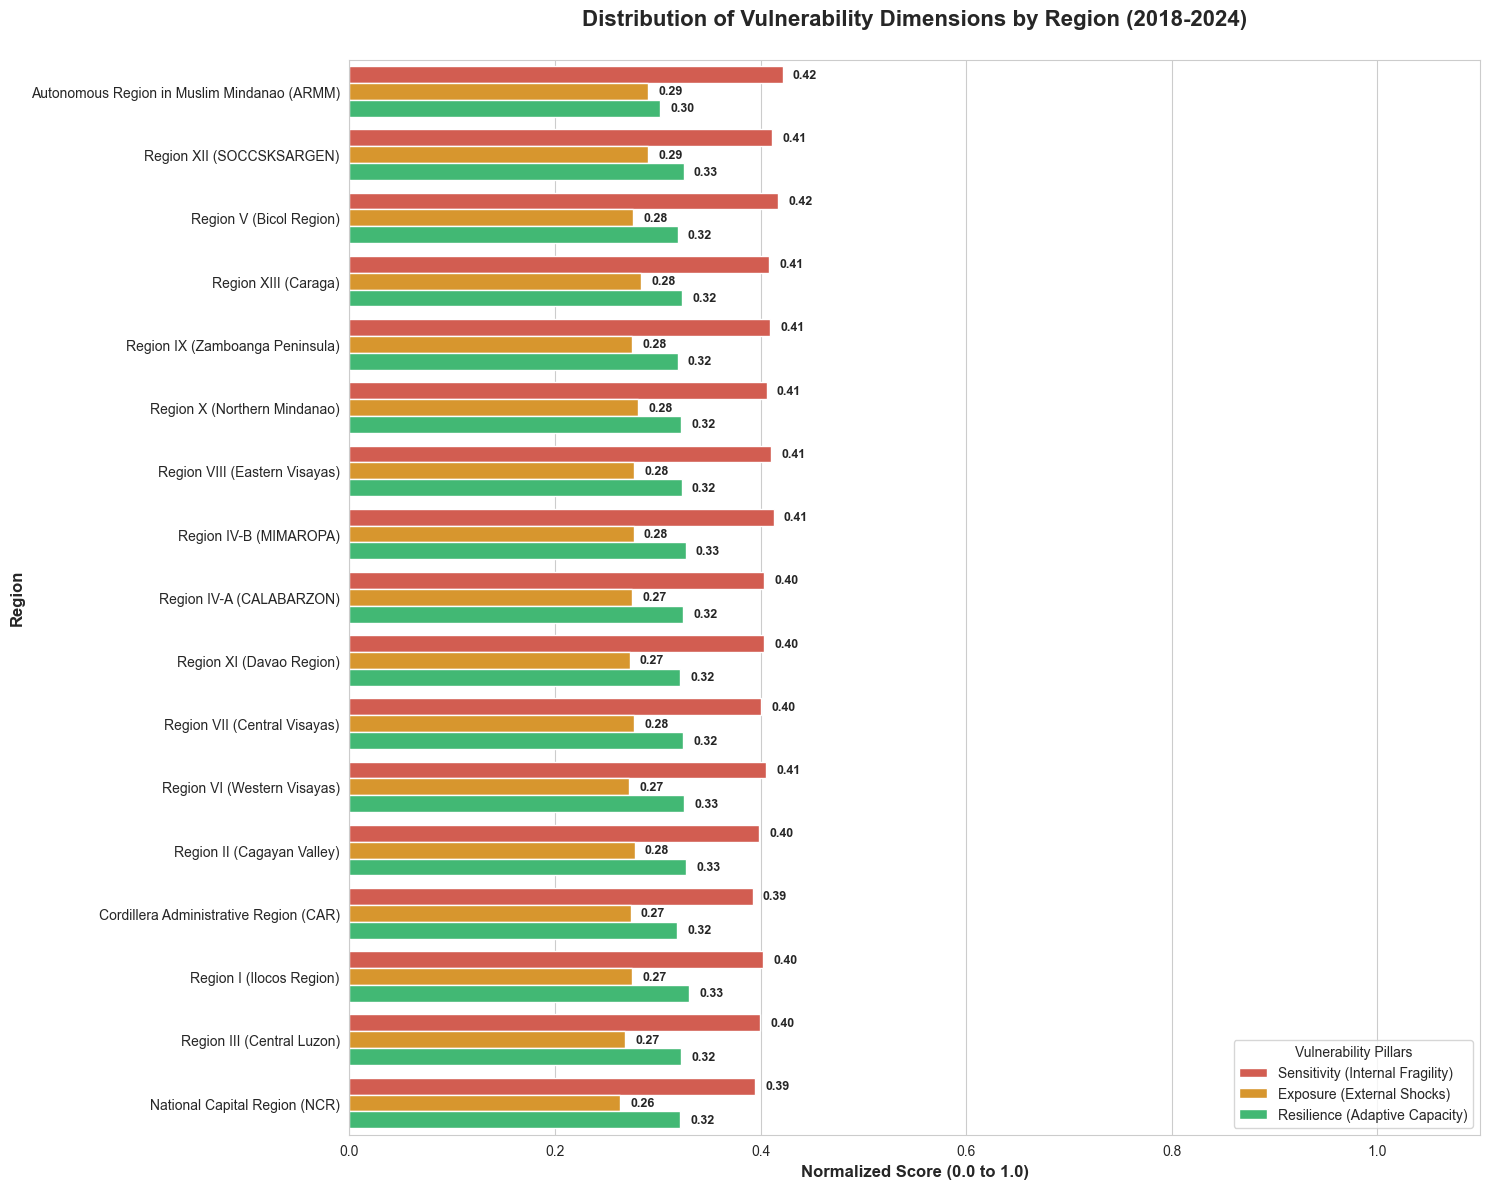

Processing Complete. Master file saved at: data\processed\rfvi_regional_distribution_master.csv


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import gc
from pathlib import Path

# --- 1. SETUP & PATH CONFIGURATION ---
SUMMARY_SRE_FILE = Path("./data/processed/rfvi_regional_distribution_master.csv")
CHECKPOINT_DIR = Path("./data/interim/sre_distribution_checkpoints")
PLOT_DIR = Path("./plots/distribution_analysis")

os.makedirs(PLOT_DIR, exist_ok=True)
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

# --- 2. DATA RECONSTRUCTION (FRESH SCAN) ---
if not SUMMARY_SRE_FILE.exists():
    print("Reconstructing regional distribution from microdata...")
    
    if ENRICHED_SOURCE.exists():
        all_files = list(ENRICHED_SOURCE.rglob("Enriched_*.csv"))
        
        for i, f in enumerate(all_files):
            # Checkpoint name unique to this folder
            checkpoint_path = CHECKPOINT_DIR / f"cp_{f.parent.name}_{f.name}"
            
            if checkpoint_path.exists():
                continue
            
            # Load S, R, E pillars + RFVI
            temp_df = pd.read_csv(f, usecols=['Region', 'Sensitivity_Score_norm', 
                                             'Resilience_Score_norm', 'Exposure_Score_norm', 'RFVI'])
            
            # Calculate monthly regional means
            monthly_means = temp_df.groupby('Region').mean().reset_index()
            monthly_means.to_csv(checkpoint_path, index=False)
            
            print(f"  Processing Month {i+1}/{len(all_files)}: {f.parent.name}".ljust(60), end="\r")
            
            del temp_df
            gc.collect()

        print("\nAll months processed. Finalizing master summary...")
        checkpoint_files = list(CHECKPOINT_DIR.glob("cp_*.csv"))
        
        if checkpoint_files:
            all_cp_data = []
            for cp in checkpoint_files:
                parts = cp.name.split('_')
                
                try:
                    y = parts[1] 
                    m = parts[2]
                    
                    m_df = pd.read_csv(cp)
                    m_df['Survey_Year'] = y
                    m_df['Survey_Month'] = m
                    all_cp_data.append(m_df)
                except IndexError:
                    continue
            
            # Combine all months
            df_master = pd.concat(all_cp_data).reset_index(drop=True)
            
            # Create static average summary 
            df_overall = df_master.groupby('Region').mean(numeric_only=True).reset_index()
            df_overall.to_csv(SUMMARY_SRE_FILE, index=False)
        else:
            print("Error: No checkpoint files found.")
    else:
        print("CRITICAL ERROR: Source microdata folder (ENRICHED_SOURCE) not found.")
else:
    print(f"Loading existing regional distribution from {SUMMARY_SRE_FILE}")
    df_overall = pd.read_csv(SUMMARY_SRE_FILE)

# --- 3. DATA PREPARATION ---
S_NORM = 'Sensitivity_Score_norm'
E_NORM = 'Exposure_Score_norm'
R_NORM = 'Resilience_Score_norm'

# Sort by RFVI (Descending) to highlight the most vulnerable regions
df_plot = df_overall.sort_values('RFVI', ascending=False)

# --- 4. VISUALIZATION: REGIONAL SRE DISTRIBUTION (GROUPED) ---
plt.figure(figsize=(15, 12))
sns.set_style("whitegrid")

df_melted = df_plot.melt(
    id_vars='Region', 
    value_vars=[S_NORM, E_NORM, R_NORM],
    var_name='Pillar', 
    value_name='Score'
)

pillar_map = {
    S_NORM: 'Sensitivity (Internal Fragility)',
    E_NORM: 'Exposure (External Shocks)',
    R_NORM: 'Resilience (Adaptive Capacity)'
}
df_melted['Pillar'] = df_melted['Pillar'].map(pillar_map)

# Short Green Bar = Low Resilience
ax = sns.barplot(
    data=df_melted, 
    y='Region', 
    x='Score', 
    hue='Pillar', 
    palette=['#e74c3c', '#f39c12', '#2ecc71']
)

plt.title("Distribution of Vulnerability Dimensions by Region (2018-2024)", 
          fontsize=16, fontweight='bold', pad=25)
plt.xlabel("Normalized Score (0.0 to 1.0)", fontsize=12, fontweight='semibold')
plt.ylabel("Region", fontsize=12, fontweight='semibold')
plt.legend(title="Vulnerability Pillars", loc='lower right', frameon=True)

# Add numeric labels to each bar for precise thesis reporting
for p in ax.patches:
    width = p.get_width()
    if width > 0:
        ax.text(width + 0.01, p.get_y() + p.get_height()/2, 
                f'{width:.2f}', va='center', fontsize=9, fontweight='bold')

plt.xlim(0, 1.1)
plt.tight_layout()

plt.savefig(PLOT_DIR / "regional_sre_distribution_grouped.png", dpi=300)
plt.show()

print(f"Processing Complete. Master file saved at: {SUMMARY_SRE_FILE}")

Interpretation:

Across all regions, the vulnerability dimensions show a consistent pattern. **Sensitivity** is the highest contributor to vulnerability, followed by **resilience**, while **exposure** is consistently the lowest. Although the relative ordering of the three dimensions is similar across regions, the **magnitude of the scores differs**, indicating variation in vulnerability intensity rather than structure. This suggests that regional differences in vulnerability are driven more by **levels of sensitivity, resilience, and exposure**, rather than by fundamentally different vulnerability profiles.